# Seasonal Analysis Per Product - Bundle Paper

## Objective
This notebook performs detailed seasonal analysis for each product to identify:
- **Best/Worst Months**: When each product performs best
- **Seasonal Patterns**: Which products are seasonal vs year-round
- **Growth Trends**: Products with increasing/decreasing seasonal trends
- **Product-Specific Insights**: Customized seasonal strategies per product

## Data Source
- `json_files/` - Products from bundle paper JSON files


In [36]:
# Import libraries
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Any, Optional
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


## Step 1: Load All JSON Files


In [37]:
# Load all JSON files from json_files folder
base_folder = 'json_files'
json_files_list = []

if os.path.exists(base_folder):
    # Get all JSON files from root and subfolders
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                json_files_list.append(file_path)
    
    print(f"✓ Found {len(json_files_list)} JSON files in {base_folder}/")
else:
    print(f"⚠ Folder {base_folder} not found")


✓ Found 16 JSON files in json_files/


## Step 2: Extract Product Information and Seasonal Trends


In [38]:
def extract_product_seasonal_data(file_path: str) -> Dict[str, Any]:
    """
    Extract product information and seasonal trends from JSON file.
    Returns both product info and seasonal trends.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        listing = data.get('listing', {})
        listing_id = listing.get('listing_id')
        title = listing.get('title', '')
        price = float(listing.get('price', 0) or 0)
        sales = int(listing.get('transaction_sold_count', 0) or 0)
        revenue = price * sales
        
        # Extract trends
        trends = listing.get('trends', [])
        if not trends:
            trends = data.get('listing_analytics_trend', [])
        
        trends_list = []
        
        for trend_data in trends:
            try:
                date_str = trend_data.get('date')
                if not date_str:
                    continue
                
                date = pd.to_datetime(date_str, errors='coerce')
                if pd.isna(date):
                    continue
                
                trend = {
                    'listing_id': listing_id,
                    'title': title,
                    'date': date,
                    'year': date.year,
                    'month': date.month,
                    'month_name': date.strftime('%B'),
                    'quarter': f"Q{(date.month-1)//3 + 1}",
                    'season': 'Spring' if date.month in [3,4,5] else 
                             'Summer' if date.month in [6,7,8] else
                             'Fall' if date.month in [9,10,11] else 'Winter',
                    'total_sales': int(trend_data.get('total_sales', 0) or 0),
                    'total_revenue': float(trend_data.get('total_revenue', 0) or 0),
                    'product_price': price,
                    'product_total_sales': sales,
                    'product_total_revenue': revenue,
                }
                trends_list.append(trend)
            except Exception:
                continue
        
        return {
            'product_info': {
                'listing_id': listing_id,
                'title': title,
                'price': price,
                'total_sales': sales,
                'total_revenue': revenue,
            },
            'trends': trends_list
        }
    except Exception as e:
        return {'product_info': None, 'trends': []}

print("✓ Extraction function defined")


✓ Extraction function defined


In [39]:
# Extract all data
all_products_info = []
all_trends = []

for file_path in json_files_list:
    data = extract_product_seasonal_data(file_path)
    if data['product_info']:
        all_products_info.append(data['product_info'])
    all_trends.extend(data['trends'])

# Create DataFrames
products_df = pd.DataFrame(all_products_info)

if all_trends:
    trends_df = pd.DataFrame(all_trends)
    trends_df['date'] = pd.to_datetime(trends_df['date'])
    print(f"\n✓ Extracted {len(trends_df)} seasonal trend records")
    print(f"  - Unique products: {trends_df['listing_id'].nunique()}")
    print(f"  - Date range: {trends_df['date'].min().strftime('%Y-%m-%d')} to {trends_df['date'].max().strftime('%Y-%m-%d')}")
else:
    trends_df = pd.DataFrame()
    print("\n⚠ No seasonal trends data found")

print(f"\n✓ Total products: {len(products_df)}")



✓ Extracted 290 seasonal trend records
  - Unique products: 16
  - Date range: 2023-09-01 to 2025-09-01

✓ Total products: 16


## Step 3: Product-Level Seasonal Analysis


In [40]:
if len(trends_df) > 0:
    # Calculate seasonal metrics for each product
    product_seasonal_analysis = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = products_df[products_df['listing_id'] == listing_id].iloc[0]
        
        # Monthly analysis
        monthly_stats = product_trends.groupby('month').agg({
            'total_revenue': 'sum',
            'total_sales': 'sum'
        }).reset_index()
        
        best_month = monthly_stats.loc[monthly_stats['total_revenue'].idxmax()]
        worst_month = monthly_stats.loc[monthly_stats['total_revenue'].idxmin()]
        
        # Seasonal analysis
        seasonal_stats = product_trends.groupby('season').agg({
            'total_revenue': 'sum',
            'total_sales': 'sum'
        }).reset_index()
        
        best_season = seasonal_stats.loc[seasonal_stats['total_revenue'].idxmax()]
        worst_season = seasonal_stats.loc[seasonal_stats['total_revenue'].idxmin()]
        
        # Calculate seasonal variation (coefficient of variation)
        monthly_revenue_std = monthly_stats['total_revenue'].std()
        monthly_revenue_mean = monthly_stats['total_revenue'].mean()
        seasonal_variation = (monthly_revenue_std / monthly_revenue_mean * 100) if monthly_revenue_mean > 0 else 0
        
        # Determine if product is seasonal (high variation) or stable (low variation)
        is_seasonal = seasonal_variation > 30  # Threshold: >30% variation indicates seasonality
        
        # Calculate growth trend (comparing first half vs second half of data)
        sorted_trends = product_trends.sort_values('date')
        mid_point = len(sorted_trends) // 2
        first_half_revenue = sorted_trends.iloc[:mid_point]['total_revenue'].sum()
        second_half_revenue = sorted_trends.iloc[mid_point:]['total_revenue'].sum()
        growth_rate = ((second_half_revenue - first_half_revenue) / first_half_revenue * 100) if first_half_revenue > 0 else 0
        
        # Calculate actual total revenue and sales from trends data (not static values)
        actual_total_revenue = product_trends['total_revenue'].sum()
        actual_total_sales = product_trends['total_sales'].sum()
        
        product_analysis = {
            'listing_id': listing_id,
            'title': product_info['title'],
            'total_revenue': actual_total_revenue,  # Use actual from trends
            'total_sales': actual_total_sales,  # Use actual from trends
            'price': product_info['price'],
            'best_month': best_month['month'],
            'best_month_revenue': best_month['total_revenue'],
            'worst_month': worst_month['month'],
            'worst_month_revenue': worst_month['total_revenue'],
            'best_season': best_season['season'],
            'best_season_revenue': best_season['total_revenue'],
            'worst_season': worst_season['season'],
            'worst_season_revenue': worst_season['total_revenue'],
            'seasonal_variation': seasonal_variation,
            'is_seasonal': is_seasonal,
            'growth_rate': growth_rate,
            'trend_records': len(product_trends),
            'months_covered': product_trends['month'].nunique(),
        }
        
        product_seasonal_analysis.append(product_analysis)
    
    # Create analysis DataFrame
    seasonal_analysis_df = pd.DataFrame(product_seasonal_analysis)
    
    print(f"✓ Seasonal analysis completed for {len(seasonal_analysis_df)} products")
    print(f"\n📊 Summary:")
    print(f"  • Seasonal products (variation > 30%): {len(seasonal_analysis_df[seasonal_analysis_df['is_seasonal'] == True])}")
    print(f"  • Stable products (variation ≤ 30%): {len(seasonal_analysis_df[seasonal_analysis_df['is_seasonal'] == False])}")
    print(f"  • Growing products (positive growth): {len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] > 0])}")
    print(f"  • Declining products (negative growth): {len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] < 0])}")
else:
    seasonal_analysis_df = pd.DataFrame()
    print("⚠ No seasonal data available for analysis")


✓ Seasonal analysis completed for 16 products

📊 Summary:
  • Seasonal products (variation > 30%): 16
  • Stable products (variation ≤ 30%): 0
  • Growing products (positive growth): 0
  • Declining products (negative growth): 16


## Step 4: Top Seasonal Products & Best/Worst Months Analysis


In [41]:
if len(seasonal_analysis_df) > 0:
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    print("="*70)
    print("BEST/WORST MONTHS PER PRODUCT")
    print("="*70)
    
    # Products sorted by total revenue
    top_products = seasonal_analysis_df.nlargest(15, 'total_revenue')
    
    print(f"\n📊 TOP 15 PRODUCTS - Best/Worst Months:")
    print("-" * 70)
    for idx, row in top_products.iterrows():
        best_month_name = month_names[int(row['best_month'])-1]
        worst_month_name = month_names[int(row['worst_month'])-1]
        print(f"\n{idx+1}. {row['title'][:55]}")
        print(f"   Best Month: {best_month_name} (${row['best_month_revenue']:,.2f})")
        print(f"   Worst Month: {worst_month_name} (${row['worst_month_revenue']:,.2f})")
        print(f"   Variation: {row['seasonal_variation']:.1f}% | {'Seasonal' if row['is_seasonal'] else 'Stable'}")
    
    # Count products by best month
    best_month_distribution = seasonal_analysis_df['best_month'].value_counts().sort_index()
    print(f"\n📅 PRODUCT DISTRIBUTION BY BEST MONTH:")
    print("-" * 70)
    for month_num, count in best_month_distribution.items():
        print(f"  {month_names[int(month_num)-1]}: {count} products peak in this month")
    
    print(f"\n💡 Insight: {best_month_distribution.idxmax()} ({month_names[int(best_month_distribution.idxmax())-1]}) is the most common peak month")
    print(f"   Consider this when planning product launches and marketing campaigns")


BEST/WORST MONTHS PER PRODUCT

📊 TOP 15 PRODUCTS - Best/Worst Months:
----------------------------------------------------------------------

3. 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pages - 
   Best Month: Nov ($188,483.76)
   Worst Month: May ($4,957.20)
   Variation: 115.5% | Seasonal

14. READING JOURNAL BUNDLE - Printable Journal Pages - Digi
   Best Month: Nov ($15,422.40)
   Worst Month: Apr ($942.48)
   Variation: 90.9% | Seasonal

4. 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - PRINTA
   Best Month: Nov ($17,148.24)
   Worst Month: May ($0.00)
   Variation: 140.7% | Seasonal

16. Yearly Trackers Bundle - PRINTABLE Journal Pages - Digi
   Best Month: Dec ($14,372.82)
   Worst Month: Apr ($314.16)
   Variation: 134.5% | Seasonal

13. Monthly Trackers Bundle - PRINTABLE Journal Pages - Dig
   Best Month: Dec ($10,110.24)
   Worst Month: Apr ($221.34)
   Variation: 131.3% | Seasonal

10. FITNESS JOURNAL BUNDLE - Printable Journal Pages - Digi
   Best Month: Nov ($6,42

## Step 5: Seasonal vs Stable Products Analysis


In [42]:
if len(seasonal_analysis_df) > 0:
    print("="*70)
    print("SEASONAL vs STABLE PRODUCTS")
    print("="*70)
    
    seasonal_products = seasonal_analysis_df[seasonal_analysis_df['is_seasonal'] == True]
    stable_products = seasonal_analysis_df[seasonal_analysis_df['is_seasonal'] == False]
    
    print(f"\n📈 SEASONAL PRODUCTS ({len(seasonal_products)} products):")
    print(f"  • Average Variation: {seasonal_products['seasonal_variation'].mean():.1f}%")
    print(f"  • Average Revenue: ${seasonal_products['total_revenue'].mean():,.2f}")
    print(f"  • Total Revenue: ${seasonal_products['total_revenue'].sum():,.2f}")
    print(f"\n  Top 5 Seasonal Products:")
    for idx, row in seasonal_products.nlargest(5, 'total_revenue').iterrows():
        print(f"    • {row['title'][:55]}")
        print(f"      Revenue: ${row['total_revenue']:,.2f} | Variation: {row['seasonal_variation']:.1f}% | Best: {row['best_season']}")
    
    print(f"\n📊 STABLE PRODUCTS ({len(stable_products)} products):")
    if len(stable_products) > 0:
        print(f"  • Average Variation: {stable_products['seasonal_variation'].mean():.1f}%")
        print(f"  • Average Revenue: ${stable_products['total_revenue'].mean():,.2f}")
        print(f"  • Total Revenue: ${stable_products['total_revenue'].sum():,.2f}")
        print(f"\n  Top 5 Stable Products:")
        for idx, row in stable_products.nlargest(5, 'total_revenue').iterrows():
            print(f"    • {row['title'][:55]}")
            print(f"      Revenue: ${row['total_revenue']:,.2f} | Variation: {row['seasonal_variation']:.1f}%")
    else:
        print(f"  • No stable products found")
    
    print(f"\n💡 Insight: Seasonal products require inventory planning around peak seasons")
    print(f"   Stable products can maintain consistent inventory levels year-round")


SEASONAL vs STABLE PRODUCTS

📈 SEASONAL PRODUCTS (16 products):
  • Average Variation: 114.2%
  • Average Revenue: $54,201.83
  • Total Revenue: $867,229.35

  Top 5 Seasonal Products:
    • 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pages - 
      Revenue: $618,034.32 | Variation: 115.5% | Best: Fall
    • READING JOURNAL BUNDLE - Printable Journal Pages - Digi
      Revenue: $64,816.92 | Variation: 90.9% | Best: Fall
    • 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - PRINTA
      Revenue: $46,671.12 | Variation: 140.7% | Best: Fall
    • Yearly Trackers Bundle - PRINTABLE Journal Pages - Digi
      Revenue: $39,541.32 | Variation: 134.5% | Best: Winter
    • Monthly Trackers Bundle - PRINTABLE Journal Pages - Dig
      Revenue: $27,410.46 | Variation: 131.3% | Best: Winter

📊 STABLE PRODUCTS (0 products):
  • No stable products found

💡 Insight: Seasonal products require inventory planning around peak seasons
   Stable products can maintain consistent inventory levels year-ro

## Step 6: Growth Trends Analysis


In [43]:
if len(seasonal_analysis_df) > 0:
    print("="*70)
    print("GROWTH TRENDS ANALYSIS")
    print("="*70)
    
    growing_products = seasonal_analysis_df[seasonal_analysis_df['growth_rate'] > 0].sort_values('growth_rate', ascending=False)
    declining_products = seasonal_analysis_df[seasonal_analysis_df['growth_rate'] < 0].sort_values('growth_rate', ascending=True)
    stable_growth = seasonal_analysis_df[abs(seasonal_analysis_df['growth_rate']) <= 5]
    
    print(f"\n📈 GROWING PRODUCTS ({len(growing_products)} products with positive growth):")
    if len(growing_products) > 0:
        print(f"  • Average Growth Rate: {growing_products['growth_rate'].mean():.1f}%")
        print(f"  • Top 5 Fastest Growing:")
        for idx, row in growing_products.head(5).iterrows():
            print(f"    • {row['title'][:55]}")
            print(f"      Growth: {row['growth_rate']:.1f}% | Revenue: ${row['total_revenue']:,.2f}")
    
    print(f"\n📉 DECLINING PRODUCTS ({len(declining_products)} products with negative growth):")
    if len(declining_products) > 0:
        print(f"  • Average Decline Rate: {declining_products['growth_rate'].mean():.1f}%")
        print(f"  • Top 5 Most Declining:")
        for idx, row in declining_products.head(5).iterrows():
            print(f"    • {row['title'][:55]}")
            print(f"      Decline: {row['growth_rate']:.1f}% | Revenue: ${row['total_revenue']:,.2f}")
    
    print(f"\n➡️ STABLE GROWTH ({len(stable_growth)} products with minimal change):")
    print(f"  • These products maintain consistent performance")
    
    print(f"\n💡 Insight: Focus marketing efforts on growing products")
    print(f"   Investigate declining products for optimization opportunities")


GROWTH TRENDS ANALYSIS

📈 GROWING PRODUCTS (0 products with positive growth):

📉 DECLINING PRODUCTS (16 products with negative growth):
  • Average Decline Rate: -72.8%
  • Top 5 Most Declining:
    • 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - PRINTA
      Decline: -93.6% | Revenue: $46,671.12
    • February Journal Bundle - Bows - PRINTABLE Journal Page
      Decline: -91.6% | Revenue: $8,439.38
    • Monthly Trackers Bundle - PRINTABLE Journal Pages - Dig
      Decline: -90.5% | Revenue: $27,410.46
    • Autumn Journal Bundle - PRINTABLE Autumn Planner - 17 J
      Decline: -87.0% | Revenue: $5,641.48
    • 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pages - 
      Decline: -85.1% | Revenue: $618,034.32

➡️ STABLE GROWTH (0 products with minimal change):
  • These products maintain consistent performance

💡 Insight: Focus marketing efforts on growing products
   Investigate declining products for optimization opportunities


## Step 7: Advanced Seasonal Insights


In [44]:
# Insight 1: Revenue Concentration Analysis
if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    print("="*70)
    print("REVENUE CONCENTRATION ANALYSIS")
    print("="*70)
    
    revenue_concentration = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        total_revenue = product_trends['total_revenue'].sum()
        if total_revenue > 0:
            # Top 3 months revenue concentration
            monthly_revenue = product_trends.groupby('month')['total_revenue'].sum().sort_values(ascending=False)
            top_3_months_revenue = monthly_revenue.head(3).sum()
            top_3_concentration = (top_3_months_revenue / total_revenue) * 100
            
            # Peak month concentration
            peak_month_revenue = monthly_revenue.iloc[0] if len(monthly_revenue) > 0 else 0
            peak_month_concentration = (peak_month_revenue / total_revenue) * 100
            
            revenue_concentration.append({
                'listing_id': listing_id,
                'title': product_info['title'],
                'total_revenue': total_revenue,
                'top_3_months_revenue': top_3_months_revenue,
                'top_3_concentration_pct': top_3_concentration,
                'peak_month_revenue': peak_month_revenue,
                'peak_month_concentration_pct': peak_month_concentration
            })
    
    concentration_df = pd.DataFrame(revenue_concentration)
    
    if len(concentration_df) > 0:
        print(f"\n📊 REVENUE CONCENTRATION INSIGHTS:")
        print(f"  • Average Top 3 Months Concentration: {concentration_df['top_3_concentration_pct'].mean():.1f}%")
        print(f"  • Average Peak Month Concentration: {concentration_df['peak_month_concentration_pct'].mean():.1f}%")
        
        high_concentration = concentration_df[concentration_df['top_3_concentration_pct'] > 60]
        print(f"\n  ⚠ HIGH CONCENTRATION PRODUCTS ({len(high_concentration)} products with >60% in top 3 months):")
        print(f"     These products are highly dependent on peak months - high risk if peak season fails")
        for idx, row in high_concentration.nlargest(5, 'total_revenue').iterrows():
            print(f"     • {row['title'][:50]}: {row['top_3_concentration_pct']:.1f}% in top 3 months")
        
        print(f"\n  ✅ WELL-DISTRIBUTED PRODUCTS ({len(concentration_df[concentration_df['top_3_concentration_pct'] < 40])} products with <40% in top 3 months):")
        print(f"     These products have more stable revenue distribution")
        
        print(f"\n💡 Insight: High concentration = higher risk but potentially higher rewards")
        print(f"   Diversify marketing to reduce dependency on peak months")


REVENUE CONCENTRATION ANALYSIS

📊 REVENUE CONCENTRATION INSIGHTS:
  • Average Top 3 Months Concentration: 66.3%
  • Average Peak Month Concentration: 30.1%

  ⚠ HIGH CONCENTRATION PRODUCTS (11 products with >60% in top 3 months):
     These products are highly dependent on peak months - high risk if peak season fails
     • 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pag: 67.1% in top 3 months
     • 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - P: 77.5% in top 3 months
     • Yearly Trackers Bundle - PRINTABLE Journal Pages -: 71.6% in top 3 months
     • Monthly Trackers Bundle - PRINTABLE Journal Pages : 71.2% in top 3 months
     • FITNESS JOURNAL BUNDLE - Printable Journal Pages -: 69.8% in top 3 months

  ✅ WELL-DISTRIBUTED PRODUCTS (0 products with <40% in top 3 months):
     These products have more stable revenue distribution

💡 Insight: High concentration = higher risk but potentially higher rewards
   Diversify marketing to reduce dependency on peak months


In [45]:
# Insight 2: Holiday Impact Analysis
if len(trends_df) > 0:
    print("\n" + "="*70)
    print("HOLIDAY IMPACT ANALYSIS")
    print("="*70)
    
    # Holiday months: Nov (Thanksgiving/Black Friday), Dec (Christmas), Jan (New Year)
    holiday_months = [11, 12, 1]
    
    holiday_impact = []
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        total_revenue = product_trends['total_revenue'].sum()
        holiday_revenue = product_trends[product_trends['month'].isin(holiday_months)]['total_revenue'].sum()
        holiday_pct = (holiday_revenue / total_revenue * 100) if total_revenue > 0 else 0
        
        holiday_impact.append({
            'listing_id': listing_id,
            'title': product_info['title'],
            'total_revenue': total_revenue,
            'holiday_revenue': holiday_revenue,
            'holiday_revenue_pct': holiday_pct
        })
    
    holiday_df = pd.DataFrame(holiday_impact)
    
    if len(holiday_df) > 0:
        print(f"\n📊 HOLIDAY SEASON PERFORMANCE (Nov, Dec, Jan):")
        print(f"  • Average Holiday Revenue: {holiday_df['holiday_revenue_pct'].mean():.1f}% of annual revenue")
        print(f"  • Total Holiday Revenue: ${holiday_df['holiday_revenue'].sum():,.2f}")
        print(f"  • Holiday Revenue Share: {holiday_df['holiday_revenue'].sum() / holiday_df['total_revenue'].sum() * 100:.1f}% of total portfolio")
        
        holiday_heavy = holiday_df[holiday_df['holiday_revenue_pct'] > 40]
        print(f"\n  🎄 HOLIDAY-HEAVY PRODUCTS ({len(holiday_heavy)} products with >40% revenue in holidays):")
        for idx, row in holiday_heavy.nlargest(5, 'total_revenue').iterrows():
            print(f"     • {row['title'][:50]}: {row['holiday_revenue_pct']:.1f}% holiday revenue")
        
        print(f"\n💡 Insight: Holiday-heavy products need aggressive Q4 marketing")
        print(f"   Plan inventory and campaigns 2-3 months before holiday season")



HOLIDAY IMPACT ANALYSIS

📊 HOLIDAY SEASON PERFORMANCE (Nov, Dec, Jan):
  • Average Holiday Revenue: 55.8% of annual revenue
  • Total Holiday Revenue: $531,982.96
  • Holiday Revenue Share: 61.3% of total portfolio

  🎄 HOLIDAY-HEAVY PRODUCTS (14 products with >40% revenue in holidays):
     • 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pag: 61.6% holiday revenue
     • READING JOURNAL BUNDLE - Printable Journal Pages -: 50.2% holiday revenue
     • 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - P: 67.3% holiday revenue
     • Yearly Trackers Bundle - PRINTABLE Journal Pages -: 71.6% holiday revenue
     • Monthly Trackers Bundle - PRINTABLE Journal Pages : 71.2% holiday revenue

💡 Insight: Holiday-heavy products need aggressive Q4 marketing
   Plan inventory and campaigns 2-3 months before holiday season


In [46]:
# Insight 3: Quarterly Performance Analysis
if len(trends_df) > 0:
    print("\n" + "="*70)
    print("QUARTERLY PERFORMANCE ANALYSIS")
    print("="*70)
    
    quarterly_performance = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        q1_revenue = product_trends[product_trends['month'].isin([1,2,3])]['total_revenue'].sum()
        q2_revenue = product_trends[product_trends['month'].isin([4,5,6])]['total_revenue'].sum()
        q3_revenue = product_trends[product_trends['month'].isin([7,8,9])]['total_revenue'].sum()
        q4_revenue = product_trends[product_trends['month'].isin([10,11,12])]['total_revenue'].sum()
        total_revenue = product_trends['total_revenue'].sum()
        
        if total_revenue > 0:
            quarterly_performance.append({
                'listing_id': listing_id,
                'title': product_info['title'],
                'q1_revenue': q1_revenue,
                'q2_revenue': q2_revenue,
                'q3_revenue': q3_revenue,
                'q4_revenue': q4_revenue,
                'q1_pct': (q1_revenue / total_revenue) * 100,
                'q2_pct': (q2_revenue / total_revenue) * 100,
                'q3_pct': (q3_revenue / total_revenue) * 100,
                'q4_pct': (q4_revenue / total_revenue) * 100,
                'best_quarter': ['Q1', 'Q2', 'Q3', 'Q4'][np.argmax([q1_revenue, q2_revenue, q3_revenue, q4_revenue])]
            })
    
    quarterly_df = pd.DataFrame(quarterly_performance)
    
    if len(quarterly_df) > 0:
        print(f"\n📊 QUARTERLY REVENUE DISTRIBUTION:")
        print(f"  • Q1 (Jan-Mar): {quarterly_df['q1_pct'].mean():.1f}% average | ${quarterly_df['q1_revenue'].sum():,.2f} total")
        print(f"  • Q2 (Apr-Jun): {quarterly_df['q2_pct'].mean():.1f}% average | ${quarterly_df['q2_revenue'].sum():,.2f} total")
        print(f"  • Q3 (Jul-Sep): {quarterly_df['q3_pct'].mean():.1f}% average | ${quarterly_df['q3_revenue'].sum():,.2f} total")
        print(f"  • Q4 (Oct-Dec): {quarterly_df['q4_pct'].mean():.1f}% average | ${quarterly_df['q4_revenue'].sum():,.2f} total")
        
        best_quarter = quarterly_df['best_quarter'].value_counts().idxmax()
        print(f"\n  🎯 BEST QUARTER: {best_quarter} ({quarterly_df['best_quarter'].value_counts()[best_quarter]} products peak in {best_quarter})")
        
        q4_products = quarterly_df[quarterly_df['best_quarter'] == 'Q4']
        print(f"\n  📈 Q4 PEAK PRODUCTS ({len(q4_products)} products):")
        print(f"     These products peak in Q4 - critical for year-end revenue")
        for idx, row in q4_products.nlargest(5, 'q4_revenue').iterrows():
            print(f"     • {row['title'][:50]}: {row['q4_pct']:.1f}% of revenue in Q4")
        
        print(f"\n💡 Insight: Q4 is typically strongest - plan inventory and marketing accordingly")



QUARTERLY PERFORMANCE ANALYSIS

📊 QUARTERLY REVENUE DISTRIBUTION:
  • Q1 (Jan-Mar): 19.4% average | $130,671.62 total
  • Q2 (Apr-Jun): 5.7% average | $38,586.88 total
  • Q3 (Jul-Sep): 20.8% average | $131,380.57 total
  • Q4 (Oct-Dec): 54.2% average | $566,590.28 total

  🎯 BEST QUARTER: Q4 (13 products peak in Q4)

  📈 Q4 PEAK PRODUCTS (13 products):
     These products peak in Q4 - critical for year-end revenue
     • 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pag: 67.1% of revenue in Q4
     • 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - P: 77.5% of revenue in Q4
     • READING JOURNAL BUNDLE - Printable Journal Pages -: 55.6% of revenue in Q4
     • Yearly Trackers Bundle - PRINTABLE Journal Pages -: 67.8% of revenue in Q4
     • Monthly Trackers Bundle - PRINTABLE Journal Pages : 66.8% of revenue in Q4

💡 Insight: Q4 is typically strongest - plan inventory and marketing accordingly


In [47]:
# Insight 4: Peak Duration & Recovery Analysis
if len(trends_df) > 0 and len(seasonal_analysis_df) > 0:
    print("\n" + "="*70)
    print("PEAK DURATION & RECOVERY ANALYSIS")
    print("="*70)
    
    peak_analysis = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        monthly_revenue = product_trends.groupby('month')['total_revenue'].sum()
        avg_revenue = monthly_revenue.mean()
        peak_threshold = avg_revenue * 1.2  # 20% above average = peak
        
        # Find peak months
        peak_months = monthly_revenue[monthly_revenue >= peak_threshold].index.tolist()
        peak_duration = len(peak_months)
        
        # Calculate recovery time (months from worst to best)
        worst_month = monthly_revenue.idxmin()
        best_month = monthly_revenue.idxmax()
        
        # Calculate months between worst and best
        if worst_month < best_month:
            recovery_time = best_month - worst_month
        else:
            recovery_time = (12 - worst_month) + best_month
        
        peak_analysis.append({
            'listing_id': listing_id,
            'title': product_info['title'],
            'peak_duration_months': peak_duration,
            'recovery_time_months': recovery_time,
            'peak_months_count': peak_duration
        })
    
    peak_duration_df = pd.DataFrame(peak_analysis)
    
    if len(peak_duration_df) > 0:
        print(f"\n📊 PEAK DURATION INSIGHTS:")
        print(f"  • Average Peak Duration: {peak_duration_df['peak_duration_months'].mean():.1f} months")
        print(f"  • Average Recovery Time: {peak_duration_df['recovery_time_months'].mean():.1f} months")
        
        long_peak = peak_duration_df[peak_duration_df['peak_duration_months'] >= 4]
        print(f"\n  ⏱️ LONG PEAK SEASON ({len(long_peak)} products with ≥4 month peaks):")
        print(f"     These products have extended peak periods - more predictable revenue")
        for idx, row in long_peak.head(5).iterrows():
            print(f"     • {row['title'][:50]}: {int(row['peak_duration_months'])} month peak")
        
        quick_recovery = peak_duration_df[peak_duration_df['recovery_time_months'] <= 3]
        print(f"\n  ⚡ QUICK RECOVERY ({len(quick_recovery)} products recover in ≤3 months):")
        print(f"     These products bounce back quickly from low seasons")
        
        print(f"\n💡 Insight: Longer peaks = more stable revenue, shorter recovery = better resilience")



PEAK DURATION & RECOVERY ANALYSIS

📊 PEAK DURATION INSIGHTS:
  • Average Peak Duration: 3.6 months
  • Average Recovery Time: 7.1 months

  ⏱️ LONG PEAK SEASON (8 products with ≥4 month peaks):
     These products have extended peak periods - more predictable revenue
     • 12 Month Title Pages - BUNDLE B - 12 Month Cover P: 4 month peak
     • 12 Month Title Pages - BUNDLE C - PRINTABLE Journa: 5 month peak
     • 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pag: 4 month peak
     • Autumn Journal Bundle - PRINTABLE Autumn Planner -: 4 month peak
     • Bucket List Bundle - PRINTABLE Journal Pages Fall : 4 month peak

  ⚡ QUICK RECOVERY (1 products recover in ≤3 months):
     These products bounce back quickly from low seasons

💡 Insight: Longer peaks = more stable revenue, shorter recovery = better resilience


In [48]:
# Insight 5: Optimal Launch Timing Analysis
if len(trends_df) > 0:
    print("\n" + "="*70)
    print("OPTIMAL LAUNCH TIMING ANALYSIS")
    print("="*70)
    
    # Analyze which months have best performance for new products
    monthly_performance = trends_df.groupby('month').agg({
        'total_revenue': 'sum',
        'total_sales': 'sum',
        'listing_id': 'nunique'
    }).reset_index()
    
    monthly_performance['avg_revenue_per_product'] = monthly_performance['total_revenue'] / monthly_performance['listing_id']
    monthly_performance['avg_sales_per_product'] = monthly_performance['total_sales'] / monthly_performance['listing_id']
    
    monthly_performance = monthly_performance.sort_values('avg_revenue_per_product', ascending=False)
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    print(f"\n📊 BEST MONTHS TO LAUNCH NEW PRODUCTS (by average revenue per product):")
    print("-" * 70)
    for idx, row in monthly_performance.head(6).iterrows():
        month_name = month_names[int(row['month'])-1]
        print(f"  {idx+1}. {month_name}: ${row['avg_revenue_per_product']:,.2f} avg revenue/product | {row['avg_sales_per_product']:.0f} avg sales/product")
    
    best_launch_month = monthly_performance.iloc[0]
    best_month_name = month_names[int(best_launch_month['month'])-1]
    
    print(f"\n  🎯 RECOMMENDED LAUNCH MONTH: {best_month_name}")
    print(f"     Average revenue per product: ${best_launch_month['avg_revenue_per_product']:,.2f}")
    print(f"     Launch 2-3 months before peak to build momentum")
    
    print(f"\n💡 Insight: Launch timing significantly impacts initial product performance")
    print(f"   Consider launching in months with high average revenue per product")



OPTIMAL LAUNCH TIMING ANALYSIS

📊 BEST MONTHS TO LAUNCH NEW PRODUCTS (by average revenue per product):
----------------------------------------------------------------------
  11. Nov: $15,776.26 avg revenue/product | 666 avg sales/product
  12. Dec: $13,001.01 avg revenue/product | 650 avg sales/product
  10. Oct: $7,076.92 avg revenue/product | 275 avg sales/product
  9. Sep: $5,350.90 avg revenue/product | 242 avg sales/product
  1. Jan: $4,471.66 avg revenue/product | 221 avg sales/product
  2. Feb: $2,467.53 avg revenue/product | 121 avg sales/product

  🎯 RECOMMENDED LAUNCH MONTH: Nov
     Average revenue per product: $15,776.26
     Launch 2-3 months before peak to build momentum

💡 Insight: Launch timing significantly impacts initial product performance
   Consider launching in months with high average revenue per product


In [49]:
# Insight 6: Seasonal Volatility Ranking
if len(seasonal_analysis_df) > 0:
    print("\n" + "="*70)
    print("SEASONAL VOLATILITY RANKING")
    print("="*70)
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Rank products by volatility (seasonal variation)
    volatility_ranking = seasonal_analysis_df.sort_values('seasonal_variation', ascending=False)
    
    print(f"\n📊 MOST VOLATILE PRODUCTS (Highest Seasonal Variation):")
    print("-" * 70)
    for idx, row in volatility_ranking.head(5).iterrows():
        print(f"  {idx+1}. {row['title'][:55]}")
        print(f"     Variation: {row['seasonal_variation']:.1f}% | Revenue: ${row['total_revenue']:,.2f}")
        print(f"     Best Month: {month_names[int(row['best_month'])-1]} | Best Season: {row['best_season']}")
    
    print(f"\n📊 LEAST VOLATILE PRODUCTS (Most Stable):")
    print("-" * 70)
    stable_ranking = seasonal_analysis_df.sort_values('seasonal_variation', ascending=True)
    for idx, row in stable_ranking.head(5).iterrows():
        print(f"  {idx+1}. {row['title'][:55]}")
        print(f"     Variation: {row['seasonal_variation']:.1f}% | Revenue: ${row['total_revenue']:,.2f}")
    
    print(f"\n💡 Insight: High volatility = higher risk but potentially higher peak rewards")
    print(f"   Low volatility = predictable cash flow, easier inventory planning")



SEASONAL VOLATILITY RANKING

📊 MOST VOLATILE PRODUCTS (Highest Seasonal Variation):
----------------------------------------------------------------------
  9. February Journal Bundle - Bows - PRINTABLE Journal Page
     Variation: 141.2% | Revenue: $8,439.38
     Best Month: Dec | Best Season: Winter
  5. Autumn Journal Bundle - PRINTABLE Autumn Planner - 17 J
     Variation: 140.8% | Revenue: $5,641.48
     Best Month: Sep | Best Season: Fall
  4. 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - PRINTA
     Variation: 140.7% | Revenue: $46,671.12
     Best Month: Nov | Best Season: Fall
  16. Yearly Trackers Bundle - PRINTABLE Journal Pages - Digi
     Variation: 134.5% | Revenue: $39,541.32
     Best Month: Dec | Best Season: Winter
  13. Monthly Trackers Bundle - PRINTABLE Journal Pages - Dig
     Variation: 131.3% | Revenue: $27,410.46
     Best Month: Dec | Best Season: Winter

📊 LEAST VOLATILE PRODUCTS (Most Stable):
-------------------------------------------------------------

## Step 7.5: Sales Performance Insights


In [50]:
# Sales Insight 1: Sales Volume Analysis
if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    print("="*70)
    print("SALES VOLUME ANALYSIS")
    print("="*70)
    
    # Calculate actual total sales from trends data for each product
    actual_sales = trends_df.groupby('listing_id').agg({
        'total_sales': 'sum'
    }).reset_index()
    actual_sales.columns = ['listing_id', 'actual_total_sales']
    
    # Merge with seasonal_analysis_df
    sales_with_info = seasonal_analysis_df.merge(actual_sales, on='listing_id', how='left')
    sales_with_info['actual_total_sales'] = sales_with_info['actual_total_sales'].fillna(0)
    
    total_sales_all = sales_with_info['actual_total_sales'].sum()
    avg_sales_per_product = sales_with_info['actual_total_sales'].mean()
    median_sales = sales_with_info['actual_total_sales'].median()
    
    print(f"\n📊 OVERALL SALES METRICS:")
    print(f"  • Total Sales Across All Products: {total_sales_all:,} units")
    print(f"  • Average Sales per Product: {avg_sales_per_product:,.0f} units")
    print(f"  • Median Sales per Product: {median_sales:,.0f} units")
    
    # Top products by sales
    top_sales_products = sales_with_info.nlargest(10, 'actual_total_sales')
    print(f"\n📈 TOP 10 PRODUCTS BY SALES VOLUME:")
    print("-" * 70)
    for idx, row in top_sales_products.iterrows():
        print(f"  {idx+1}. {row['title'][:55]}")
        print(f"     Sales: {row['actual_total_sales']:,.0f} units | Revenue: ${row['total_revenue']:,.2f} | Price: ${row['price']:.2f}")
    
    # Best/Worst months for sales
    if len(trends_df) > 0:
        monthly_sales = trends_df.groupby('month').agg({
            'total_sales': 'sum',
            'listing_id': 'nunique'
        }).reset_index()
        monthly_sales['avg_sales_per_product'] = monthly_sales['total_sales'] / monthly_sales['listing_id']
        monthly_sales = monthly_sales.sort_values('total_sales', ascending=False)
        
        print(f"\n📅 BEST MONTHS FOR SALES:")
        print("-" * 70)
        for idx, row in monthly_sales.head(5).iterrows():
            month_name = month_names[int(row['month'])-1]
            print(f"  {idx+1}. {month_name}: {row['total_sales']:,} total sales | {row['avg_sales_per_product']:.0f} avg sales/product")
        
        worst_month = monthly_sales.iloc[-1]
        worst_month_name = month_names[int(worst_month['month'])-1]
        print(f"\n📉 WORST MONTH FOR SALES:")
        print(f"  • {worst_month_name}: {worst_month['total_sales']:,} total sales | {worst_month['avg_sales_per_product']:.0f} avg sales/product")
        
        # Sales vs Revenue correlation
        if len(sales_with_info) > 0:
            sales_revenue_corr = sales_with_info['actual_total_sales'].corr(sales_with_info['total_revenue'])
            print(f"\n📊 SALES-REVENUE CORRELATION:")
            print(f"  • Correlation Coefficient: {sales_revenue_corr:.3f}")
            if sales_revenue_corr > 0.8:
                print(f"  • Strong positive correlation - sales volume directly drives revenue")
            elif sales_revenue_corr > 0.5:
                print(f"  • Moderate positive correlation - sales volume is a key revenue driver")
            else:
                print(f"  • Weak correlation - price variations may be significant")
    
    print(f"\n💡 Insight: Focus on high-volume months for inventory planning")
    print(f"   Products with high sales volumes may need different marketing strategies")


SALES VOLUME ANALYSIS

📊 OVERALL SALES METRICS:
  • Total Sales Across All Products: 40,474 units
  • Average Sales per Product: 2,530 units
  • Median Sales per Product: 978 units

📈 TOP 10 PRODUCTS BY SALES VOLUME:
----------------------------------------------------------------------
  3. 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pages - 
     Sales: 16,831 units | Revenue: $618,034.32 | Price: $36.72
  16. Yearly Trackers Bundle - PRINTABLE Journal Pages - Digi
     Sales: 5,538 units | Revenue: $39,541.32 | Price: $7.14
  13. Monthly Trackers Bundle - PRINTABLE Journal Pages - Dig
     Sales: 3,839 units | Revenue: $27,410.46 | Price: $7.14
  14. READING JOURNAL BUNDLE - Printable Journal Pages - Digi
     Sales: 3,026 units | Revenue: $64,816.92 | Price: $21.42
  7. Christmas Journal Bundle - PRINTABLE A5 Journal Pages -
     Sales: 1,292 units | Revenue: $5,620.20 | Price: $4.35
  4. 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - PRINTA
     Sales: 1,271 units | Revenue: 

In [51]:
# Sales Insight 2: Sales Concentration Analysis
if len(trends_df) > 0 and len(seasonal_analysis_df) > 0:
    print("\n" + "="*70)
    print("SALES CONCENTRATION ANALYSIS")
    print("="*70)
    
    sales_concentration = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        total_sales = product_trends['total_sales'].sum()
        if total_sales > 0:
            # Top 3 months sales concentration
            monthly_sales = product_trends.groupby('month')['total_sales'].sum().sort_values(ascending=False)
            top_3_months_sales = monthly_sales.head(3).sum()
            top_3_concentration = (top_3_months_sales / total_sales) * 100
            
            # Peak month sales concentration
            peak_month_sales = monthly_sales.iloc[0] if len(monthly_sales) > 0 else 0
            peak_month_concentration = (peak_month_sales / total_sales) * 100
            
            sales_concentration.append({
                'listing_id': listing_id,
                'title': product_info['title'],
                'total_sales': total_sales,
                'total_revenue': product_info['total_revenue'],
                'top_3_months_sales': top_3_months_sales,
                'top_3_concentration_pct': top_3_concentration,
                'peak_month_sales': peak_month_sales,
                'peak_month_concentration_pct': peak_month_concentration
            })
    
    sales_concentration_df = pd.DataFrame(sales_concentration)
    
    if len(sales_concentration_df) > 0:
        print(f"\n📊 SALES CONCENTRATION INSIGHTS:")
        print(f"  • Average Top 3 Months Sales Concentration: {sales_concentration_df['top_3_concentration_pct'].mean():.1f}%")
        print(f"  • Average Peak Month Sales Concentration: {sales_concentration_df['peak_month_concentration_pct'].mean():.1f}%")
        
        high_sales_concentration = sales_concentration_df[sales_concentration_df['top_3_concentration_pct'] > 60]
        print(f"\n  ⚠ HIGH SALES CONCENTRATION ({len(high_sales_concentration)} products with >60% sales in top 3 months):")
        print(f"     These products have highly concentrated sales patterns")
        for idx, row in high_sales_concentration.nlargest(5, 'total_sales').iterrows():
            print(f"     • {row['title'][:50]}: {row['top_3_concentration_pct']:.1f}% in top 3 months | {row['total_sales']:,} total sales")
        
        print(f"\n💡 Insight: High sales concentration indicates seasonal demand spikes")
        print(f"   Plan inventory and fulfillment capacity for peak sales months")



SALES CONCENTRATION ANALYSIS

📊 SALES CONCENTRATION INSIGHTS:
  • Average Top 3 Months Sales Concentration: 66.3%
  • Average Peak Month Sales Concentration: 30.1%

  ⚠ HIGH SALES CONCENTRATION (11 products with >60% sales in top 3 months):
     These products have highly concentrated sales patterns
     • 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pag: 67.1% in top 3 months | 16,831 total sales
     • Yearly Trackers Bundle - PRINTABLE Journal Pages -: 71.6% in top 3 months | 5,538 total sales
     • Monthly Trackers Bundle - PRINTABLE Journal Pages : 71.2% in top 3 months | 3,839 total sales
     • Christmas Journal Bundle - PRINTABLE A5 Journal Pa: 66.2% in top 3 months | 1,292 total sales
     • 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - P: 77.5% in top 3 months | 1,271 total sales

💡 Insight: High sales concentration indicates seasonal demand spikes
   Plan inventory and fulfillment capacity for peak sales months


In [52]:
# Sales Insight 3: Sales Performance by Season
if len(trends_df) > 0:
    print("\n" + "="*70)
    print("SALES PERFORMANCE BY SEASON")
    print("="*70)
    
    seasonal_sales = trends_df.groupby('season').agg({
        'total_sales': 'sum',
        'total_revenue': 'sum',
        'listing_id': 'nunique'
    }).reset_index()
    
    seasonal_sales['avg_sales_per_product'] = seasonal_sales['total_sales'] / seasonal_sales['listing_id']
    seasonal_sales = seasonal_sales.sort_values('total_sales', ascending=False)
    
    print(f"\n📊 SEASONAL SALES BREAKDOWN:")
    print("-" * 70)
    for idx, row in seasonal_sales.iterrows():
        sales_pct = (row['total_sales'] / seasonal_sales['total_sales'].sum() * 100)
        print(f"  • {row['season']}: {row['total_sales']:,} sales ({sales_pct:.1f}%) | ${row['total_revenue']:,.2f} revenue")
        print(f"    Average: {row['avg_sales_per_product']:.0f} sales/product")
    
    best_sales_season = seasonal_sales.iloc[0]
    print(f"\n🏆 BEST SALES SEASON: {best_sales_season['season']}")
    print(f"   Total Sales: {best_sales_season['total_sales']:,} units")
    print(f"   Revenue: ${best_sales_season['total_revenue']:,.2f}")
    
    # Quarterly sales breakdown
    quarterly_sales = []
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        
        q1_sales = product_trends[product_trends['month'].isin([1,2,3])]['total_sales'].sum()
        q2_sales = product_trends[product_trends['month'].isin([4,5,6])]['total_sales'].sum()
        q3_sales = product_trends[product_trends['month'].isin([7,8,9])]['total_sales'].sum()
        q4_sales = product_trends[product_trends['month'].isin([10,11,12])]['total_sales'].sum()
        total_sales = product_trends['total_sales'].sum()
        
        if total_sales > 0:
            quarterly_sales.append({
                'listing_id': listing_id,
                'q1_sales': q1_sales,
                'q2_sales': q2_sales,
                'q3_sales': q3_sales,
                'q4_sales': q4_sales,
                'total_sales': total_sales
            })
    
    if len(quarterly_sales) > 0:
        quarterly_sales_df = pd.DataFrame(quarterly_sales)
        print(f"\n📅 QUARTERLY SALES DISTRIBUTION:")
        print(f"  • Q1: {quarterly_sales_df['q1_sales'].sum():,} sales ({(quarterly_sales_df['q1_sales'].sum()/quarterly_sales_df['total_sales'].sum()*100):.1f}%)")
        print(f"  • Q2: {quarterly_sales_df['q2_sales'].sum():,} sales ({(quarterly_sales_df['q2_sales'].sum()/quarterly_sales_df['total_sales'].sum()*100):.1f}%)")
        print(f"  • Q3: {quarterly_sales_df['q3_sales'].sum():,} sales ({(quarterly_sales_df['q3_sales'].sum()/quarterly_sales_df['total_sales'].sum()*100):.1f}%)")
        print(f"  • Q4: {quarterly_sales_df['q4_sales'].sum():,} sales ({(quarterly_sales_df['q4_sales'].sum()/quarterly_sales_df['total_sales'].sum()*100):.1f}%)")
    
    print(f"\n💡 Insight: Align inventory and fulfillment capacity with peak sales seasons")



SALES PERFORMANCE BY SEASON

📊 SEASONAL SALES BREAKDOWN:
----------------------------------------------------------------------
  • Fall: 18,638 sales (46.0%) | $444,188.40 revenue
    Average: 1165 sales/product
  • Winter: 15,886 sales (39.2%) | $319,043.20 revenue
    Average: 993 sales/product
  • Summer: 3,782 sales (9.3%) | $60,745.74 revenue
    Average: 236 sales/product
  • Spring: 2,168 sales (5.4%) | $43,252.01 revenue
    Average: 136 sales/product

🏆 BEST SALES SEASON: Fall
   Total Sales: 18,638 units
   Revenue: $444,188.40

📅 QUARTERLY SALES DISTRIBUTION:
  • Q1: 6,564 sales (16.2%)
  • Q2: 1,917 sales (4.7%)
  • Q3: 6,816 sales (16.8%)
  • Q4: 25,177 sales (62.2%)

💡 Insight: Align inventory and fulfillment capacity with peak sales seasons


In [53]:
# Sales Insight 4: Sales Growth & Trends Analysis
if len(trends_df) > 0 and len(seasonal_analysis_df) > 0:
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    print("\n" + "="*70)
    print("SALES GROWTH & TRENDS ANALYSIS")
    print("="*70)
    
    sales_growth = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        # Calculate sales growth (first half vs second half)
        sorted_trends = product_trends.sort_values('date')
        mid_point = len(sorted_trends) // 2
        first_half_sales = sorted_trends.iloc[:mid_point]['total_sales'].sum()
        second_half_sales = sorted_trends.iloc[mid_point:]['total_sales'].sum()
        sales_growth_rate = ((second_half_sales - first_half_sales) / first_half_sales * 100) if first_half_sales > 0 else 0
        
        # Best and worst months for sales
        monthly_sales = product_trends.groupby('month')['total_sales'].sum()
        best_sales_month = monthly_sales.idxmax() if len(monthly_sales) > 0 else None
        worst_sales_month = monthly_sales.idxmin() if len(monthly_sales) > 0 else None
        best_sales_value = monthly_sales.max() if len(monthly_sales) > 0 else 0
        worst_sales_value = monthly_sales.min() if len(monthly_sales) > 0 else 0
        
        sales_growth.append({
            'listing_id': listing_id,
            'title': product_info['title'],
            'total_sales': product_info['total_sales'],
            'sales_growth_rate': sales_growth_rate,
            'best_sales_month': best_sales_month,
            'worst_sales_month': worst_sales_month,
            'best_sales_value': best_sales_value,
            'worst_sales_value': worst_sales_value
        })
    
    sales_growth_df = pd.DataFrame(sales_growth)
    
    if len(sales_growth_df) > 0:
        print(f"\n📊 SALES GROWTH INSIGHTS:")
        print(f"  • Average Sales Growth Rate: {sales_growth_df['sales_growth_rate'].mean():.1f}%")
        
        growing_sales = sales_growth_df[sales_growth_df['sales_growth_rate'] > 0]
        declining_sales = sales_growth_df[sales_growth_df['sales_growth_rate'] < 0]
        
        print(f"\n📈 GROWING SALES ({len(growing_sales)} products with positive growth):")
        if len(growing_sales) > 0:
            print(f"  • Average Growth: {growing_sales['sales_growth_rate'].mean():.1f}%")
            print(f"  • Top 5 Fastest Growing:")
            for idx, row in growing_sales.nlargest(5, 'sales_growth_rate').iterrows():
                print(f"    • {row['title'][:50]}")
                print(f"      Growth: {row['sales_growth_rate']:.1f}% | Total Sales: {row['total_sales']:,}")
        
        print(f"\n📉 DECLINING SALES ({len(declining_sales)} products with negative growth):")
        if len(declining_sales) > 0:
            print(f"  • Average Decline: {declining_sales['sales_growth_rate'].mean():.1f}%")
            print(f"  • Top 5 Most Declining:")
            for idx, row in declining_sales.nsmallest(5, 'sales_growth_rate').iterrows():
                print(f"    • {row['title'][:50]}")
                print(f"      Decline: {row['sales_growth_rate']:.1f}% | Total Sales: {row['total_sales']:,}")
        
        # Best sales months distribution
        best_sales_months = sales_growth_df['best_sales_month'].value_counts().sort_index()
        print(f"\n📅 PRODUCT DISTRIBUTION BY BEST SALES MONTH:")
        for month_num, count in best_sales_months.items():
            if pd.notna(month_num):
                print(f"  • {month_names[int(month_num)-1]}: {count} products peak in sales")
        
        print(f"\n💡 Insight: Growing sales products need inventory scaling")
        print(f"   Declining sales products may need marketing refresh or optimization")



SALES GROWTH & TRENDS ANALYSIS

📊 SALES GROWTH INSIGHTS:
  • Average Sales Growth Rate: -72.8%

📈 GROWING SALES (0 products with positive growth):

📉 DECLINING SALES (16 products with negative growth):
  • Average Decline: -72.8%
  • Top 5 Most Declining:
    • 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - P
      Decline: -93.6% | Total Sales: 1,271
    • February Journal Bundle - Bows - PRINTABLE Journal
      Decline: -91.6% | Total Sales: 739
    • Monthly Trackers Bundle - PRINTABLE Journal Pages 
      Decline: -90.5% | Total Sales: 3,839
    • Autumn Journal Bundle - PRINTABLE Autumn Planner -
      Decline: -87.0% | Total Sales: 988
    • 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pag
      Decline: -85.1% | Total Sales: 16,831

📅 PRODUCT DISTRIBUTION BY BEST SALES MONTH:
  • Sep: 2 products peak in sales
  • Nov: 7 products peak in sales
  • Dec: 7 products peak in sales

💡 Insight: Growing sales products need inventory scaling
   Declining sales products may need mark

In [54]:
# Sales Insight 5: Average Order Value & Price Analysis
if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    print("\n" + "="*70)
    print("AVERAGE ORDER VALUE & PRICE ANALYSIS")
    print("="*70)
    
    # Calculate actual total revenue and sales from trends data
    actual_metrics = trends_df.groupby('listing_id').agg({
        'total_revenue': 'sum',
        'total_sales': 'sum'
    }).reset_index()
    actual_metrics.columns = ['listing_id', 'actual_total_revenue', 'actual_total_sales']
    
    # Merge with seasonal_analysis_df
    metrics_with_info = seasonal_analysis_df.merge(actual_metrics, on='listing_id', how='left')
    metrics_with_info['actual_total_revenue'] = metrics_with_info['actual_total_revenue'].fillna(0)
    metrics_with_info['actual_total_sales'] = metrics_with_info['actual_total_sales'].fillna(0)
    
    # Calculate AOV (Average Order Value) = Revenue / Sales
    metrics_with_info['aov'] = metrics_with_info['actual_total_revenue'] / metrics_with_info['actual_total_sales']
    metrics_with_info['aov'] = metrics_with_info['aov'].replace([np.inf, -np.inf], np.nan)
    
    avg_aov = metrics_with_info['aov'].mean()
    median_aov = metrics_with_info['aov'].median()
    avg_price = metrics_with_info['price'].mean()
    
    print(f"\n📊 PRICING & VALUE METRICS:")
    print(f"  • Average Price: ${avg_price:.2f}")
    print(f"  • Average Order Value (AOV): ${avg_aov:.2f}")
    print(f"  • Median AOV: ${median_aov:.2f}")
    
    # Products with highest AOV
    high_aov = metrics_with_info.nlargest(5, 'aov')
    print(f"\n💰 HIGHEST AOV PRODUCTS:")
    print("-" * 70)
    for idx, row in high_aov.iterrows():
        print(f"  • {row['title'][:50]}")
        print(f"    AOV: ${row['aov']:.2f} | Price: ${row['price']:.2f} | Sales: {row['actual_total_sales']:,.0f}")
    
    # Price vs Sales correlation
    price_sales_corr = metrics_with_info['price'].corr(metrics_with_info['actual_total_sales'])
    print(f"\n📊 PRICE-SALES CORRELATION:")
    print(f"  • Correlation Coefficient: {price_sales_corr:.3f}")
    if price_sales_corr < -0.3:
        print(f"  • Negative correlation - lower prices may drive higher sales")
    elif price_sales_corr > 0.3:
        print(f"  • Positive correlation - premium pricing may indicate quality/value")
    else:
        print(f"  • Weak correlation - price may not be primary sales driver")
    
    # Sales efficiency (sales per dollar of price)
    metrics_with_info['sales_efficiency'] = metrics_with_info['actual_total_sales'] / metrics_with_info['price']
    most_efficient = metrics_with_info.nlargest(5, 'sales_efficiency')
    
    print(f"\n⚡ MOST SALES-EFFICIENT PRODUCTS (Sales per $1 of price):")
    print("-" * 70)
    for idx, row in most_efficient.iterrows():
        print(f"  • {row['title'][:50]}")
        print(f"    Efficiency: {row['sales_efficiency']:.2f} sales/$ | Price: ${row['price']:.2f} | Total Sales: {row['actual_total_sales']:,.0f}")
    
    print(f"\n💡 Insight: AOV helps understand customer value perception")
    print(f"   Sales efficiency indicates price competitiveness and market fit")



AVERAGE ORDER VALUE & PRICE ANALYSIS

📊 PRICING & VALUE METRICS:
  • Average Price: $11.73
  • Average Order Value (AOV): $11.73
  • Median AOV: $7.14

💰 HIGHEST AOV PRODUCTS:
----------------------------------------------------------------------
  • 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pag
    AOV: $36.72 | Price: $36.72 | Sales: 16,831
  • 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - P
    AOV: $36.72 | Price: $36.72 | Sales: 1,271
  • FITNESS JOURNAL BUNDLE - Printable Journal Pages -
    AOV: $21.42 | Price: $21.42 | Sales: 948
  • READING JOURNAL BUNDLE - Printable Journal Pages -
    AOV: $21.42 | Price: $21.42 | Sales: 3,026
  • February Journal Bundle - Bows - PRINTABLE Journal
    AOV: $11.42 | Price: $11.42 | Sales: 739

📊 PRICE-SALES CORRELATION:
  • Correlation Coefficient: 0.574
  • Positive correlation - premium pricing may indicate quality/value

⚡ MOST SALES-EFFICIENT PRODUCTS (Sales per $1 of price):
------------------------------------------------------

In [55]:
# Export Sales Insights to CSV
if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    os.makedirs('csv_exports/bundle_paper_analysis', exist_ok=True)
    
    exported_sales = []
    
    # Calculate actual metrics from trends data
    actual_metrics = trends_df.groupby('listing_id').agg({
        'total_revenue': 'sum',
        'total_sales': 'sum'
    }).reset_index()
    actual_metrics.columns = ['listing_id', 'actual_total_revenue', 'actual_total_sales']
    
    # Merge with seasonal_analysis_df
    metrics_with_info = seasonal_analysis_df.merge(actual_metrics, on='listing_id', how='left')
    metrics_with_info['actual_total_revenue'] = metrics_with_info['actual_total_revenue'].fillna(0)
    metrics_with_info['actual_total_sales'] = metrics_with_info['actual_total_sales'].fillna(0)
    
    # Export sales concentration
    if 'sales_concentration_df' in globals() and len(sales_concentration_df) > 0:
        try:
            sales_concentration_df.to_csv('csv_exports/bundle_paper_analysis/sales_concentration_analysis.csv', 
                                          index=False, encoding='utf-8')
            exported_sales.append('sales_concentration_analysis.csv')
            print("✓ Exported: sales_concentration_analysis.csv")
        except:
            pass
    
    # Export sales growth
    if 'sales_growth_df' in globals() and len(sales_growth_df) > 0:
        try:
            sales_growth_df.to_csv('csv_exports/bundle_paper_analysis/sales_growth_analysis.csv', 
                                   index=False, encoding='utf-8')
            exported_sales.append('sales_growth_analysis.csv')
            print("✓ Exported: sales_growth_analysis.csv")
        except:
            pass
    
    # Export sales data with AOV (using actual metrics)
    try:
        # Calculate AOV and sales efficiency
        metrics_with_info['aov'] = metrics_with_info['actual_total_revenue'] / metrics_with_info['actual_total_sales']
        metrics_with_info['aov'] = metrics_with_info['aov'].replace([np.inf, -np.inf], np.nan)
        metrics_with_info['sales_efficiency'] = metrics_with_info['actual_total_sales'] / metrics_with_info['price']
        
        sales_aov_df = metrics_with_info[['listing_id', 'title', 'price', 'actual_total_sales', 'actual_total_revenue', 'aov', 'sales_efficiency']].copy()
        sales_aov_df.columns = ['listing_id', 'title', 'price', 'total_sales', 'total_revenue', 'aov', 'sales_efficiency']
        sales_aov_df.to_csv('csv_exports/bundle_paper_analysis/sales_aov_analysis.csv', 
                            index=False, encoding='utf-8')
        exported_sales.append('sales_aov_analysis.csv')
        print("✓ Exported: sales_aov_analysis.csv")
    except Exception as e:
        pass
    
    if len(exported_sales) > 0:
        print(f"\n✅ Exported {len(exported_sales)} sales insight files")
    else:
        print("\n⚠ No sales insights to export")


✓ Exported: sales_concentration_analysis.csv
✓ Exported: sales_growth_analysis.csv
✓ Exported: sales_aov_analysis.csv

✅ Exported 3 sales insight files


🔍 Debug: Top 10 Sales Values (from trends data):
  2025 / 2026 JOURNAL BUNDLE - PRINTABLE J: 16,831 sales
  Yearly Trackers Bundle - PRINTABLE Journ: 5,538 sales
  Monthly Trackers Bundle - PRINTABLE Jour: 3,839 sales
  READING JOURNAL BUNDLE - Printable Journ: 3,026 sales
  Christmas Journal Bundle - PRINTABLE A5 : 1,292 sales
  2025 / 2026 Journal Bundle SOUTHERN HEMI: 1,271 sales
  12 Month Title Pages - BUNDLE C - PRINTA: 1,195 sales
  Autumn Journal Bundle - PRINTABLE Autumn: 988 sales
  Doodle of the Day Bundle - BUNDLE A - PR: 969 sales
  Fitness Trackers Bundle - PRINTABLE Jour: 950 sales


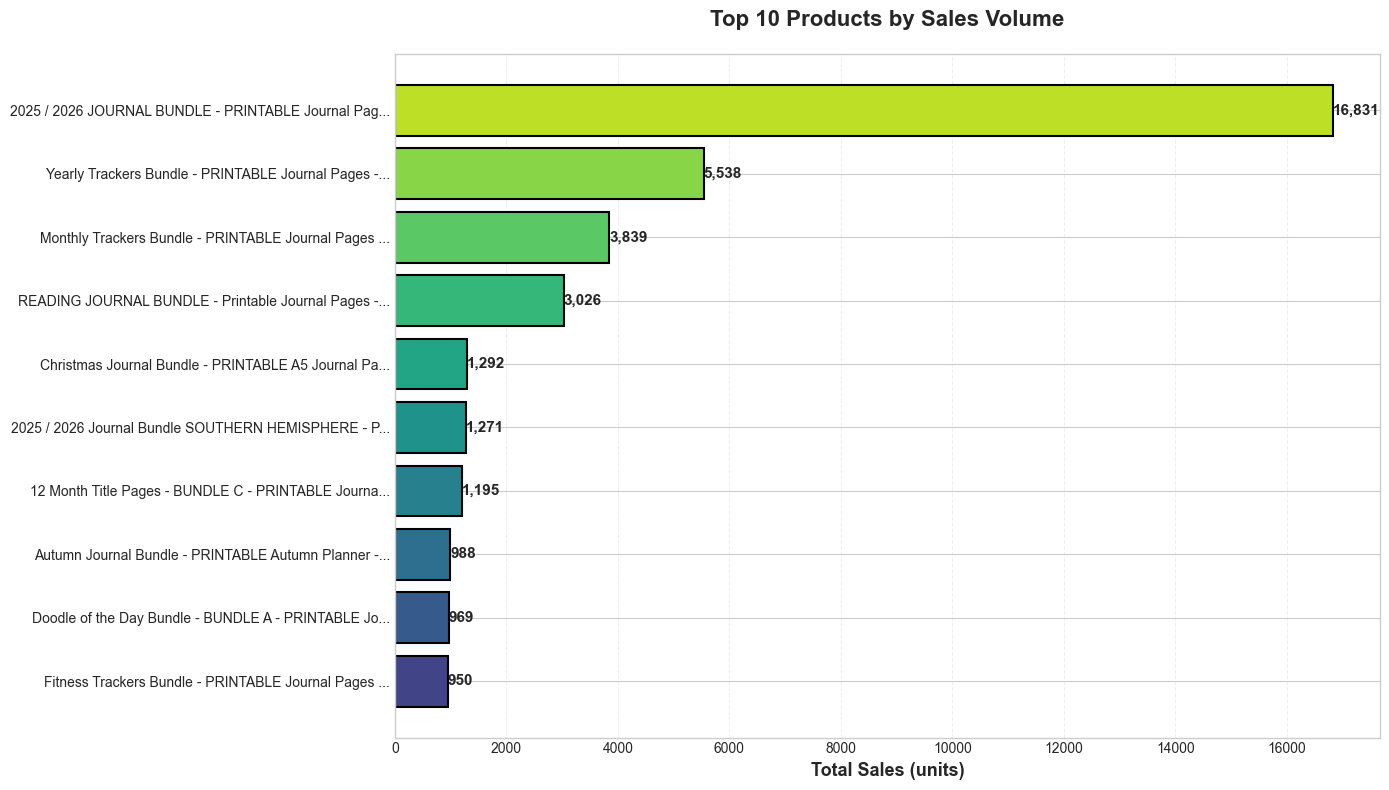


✅ Top Sales Products
   • Top product: 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pages - Digit
   • Top product sales: 16,831 units
   • Top 10 products generate: 35,899 sales
   • This represents 88.7% of total sales


In [56]:
# Sales Visualization: Top Products by Sales Volume
if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    # Calculate actual total sales from trends data for each product
    actual_sales = trends_df.groupby('listing_id').agg({
        'total_sales': 'sum',
        'title': 'first'
    }).reset_index()
    actual_sales.columns = ['listing_id', 'actual_total_sales', 'title']
    
    # Merge with seasonal_analysis_df to get all product info
    sales_with_info = seasonal_analysis_df.merge(actual_sales[['listing_id', 'actual_total_sales']], 
                                                   on='listing_id', how='left')
    
    # Sort by actual_total_sales in descending order and take top 10
    top_10_sales = sales_with_info.sort_values('actual_total_sales', ascending=False).head(10).copy()
    
    # Debug: Print the actual values to verify
    print("🔍 Debug: Top 10 Sales Values (from trends data):")
    for idx, row in top_10_sales.iterrows():
        print(f"  {row['title'][:40]}: {row['actual_total_sales']:,} sales")
    
    # Reverse order for horizontal bar chart (highest at top)
    top_10_sales = top_10_sales.sort_values('actual_total_sales', ascending=True)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(top_10_sales)))
    bars = ax.barh(range(len(top_10_sales)), top_10_sales['actual_total_sales'].values, 
                   color=colors, edgecolor='black', linewidth=1.5)
    
    titles = [title[:50] + '...' if len(title) > 50 else title for title in top_10_sales['title'].values]
    ax.set_yticks(range(len(top_10_sales)))
    ax.set_yticklabels(titles, fontsize=10)
    ax.set_xlabel('Total Sales (units)', fontsize=13, fontweight='bold')
    ax.set_title('Top 10 Products by Sales Volume', fontsize=16, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, top_10_sales['actual_total_sales'].values)):
        if value > 0:  # Only add label if value is greater than 0
            ax.text(value, bar.get_y() + bar.get_height()/2,
                    f'{int(value):,}', ha='left', va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Get the top product (highest sales)
    top_product = sales_with_info.sort_values('actual_total_sales', ascending=False).iloc[0]
    total_sales_all = sales_with_info['actual_total_sales'].sum()
    top_10_total = top_10_sales['actual_total_sales'].sum()
    
    print(f"\n✅ Top Sales Products")
    print(f"   • Top product: {top_product['title'][:60]}")
    print(f"   • Top product sales: {top_product['actual_total_sales']:,} units")
    print(f"   • Top 10 products generate: {top_10_total:,} sales")
    print(f"   • This represents {top_10_total/total_sales_all*100:.1f}% of total sales")
else:
    print("⚠ No data available for visualization")


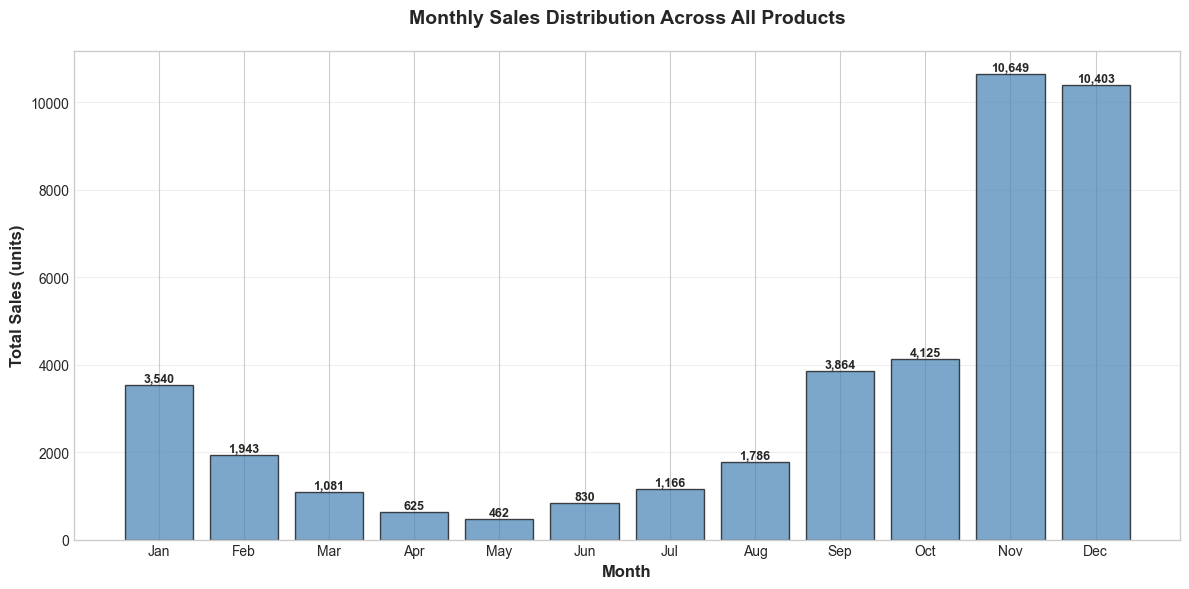

📊 Chart shows: Sales distribution across months
   Insight: Nov has highest sales (10,649 units)
   Plan inventory and fulfillment capacity for peak sales months


In [57]:
# Sales Visualization: Monthly Sales Distribution
if len(trends_df) > 0:
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    monthly_sales = trends_df.groupby('month').agg({
        'total_sales': 'sum'
    }).reset_index()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(1, 13), [monthly_sales[monthly_sales['month']==i]['total_sales'].sum() if len(monthly_sales[monthly_sales['month']==i]) > 0 else 0 for i in range(1, 13)], 
                  color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names)
    ax.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Sales (units)', fontsize=12, fontweight='bold')
    ax.set_title('Monthly Sales Distribution Across All Products', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, month in enumerate(range(1, 13)):
        sales_value = monthly_sales[monthly_sales['month']==month]['total_sales'].sum() if len(monthly_sales[monthly_sales['month']==month]) > 0 else 0
        if sales_value > 0:
            ax.text(i+1, sales_value, f'{int(sales_value):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    best_sales_month = monthly_sales.loc[monthly_sales['total_sales'].idxmax()]
    print(f"📊 Chart shows: Sales distribution across months")
    print(f"   Insight: {month_names[int(best_sales_month['month'])-1]} has highest sales ({best_sales_month['total_sales']:,.0f} units)")
    print("   Plan inventory and fulfillment capacity for peak sales months")
else:
    print("⚠ No data available for visualization")


## Step 8: Visualizations - Product Seasonal Patterns


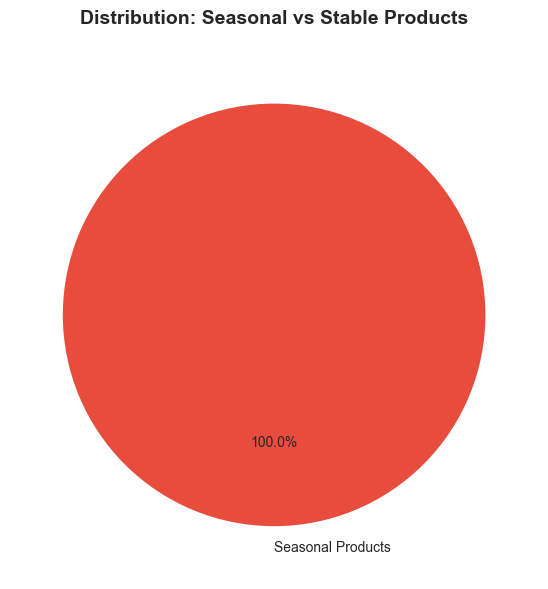

📊 Chart shows: Proportion of seasonal vs stable products
   Insight: 16 products (100.0%) are seasonal
            0 products (0.0%) are stable
   Seasonal products need different inventory and marketing strategies


In [58]:
if len(trends_df) > 0 and len(seasonal_analysis_df) > 0:
    # Visualization 1: Seasonal vs Stable Products Distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    seasonal_counts = seasonal_analysis_df['is_seasonal'].value_counts()
    
    # Create labels and colors dynamically based on what's in the data
    labels = []
    colors_list = []
    values = []
    
    if True in seasonal_counts.index:
        labels.append('Seasonal Products')
        colors_list.append('#e74c3c')
        values.append(seasonal_counts[True])
    
    if False in seasonal_counts.index:
        labels.append('Stable Products')
        colors_list.append('#3498db')
        values.append(seasonal_counts[False])
    
    if len(values) > 0:
        ax.pie(values, labels=labels, autopct='%1.1f%%', colors=colors_list, startangle=90)
        ax.set_title('Distribution: Seasonal vs Stable Products', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        seasonal_count = len(seasonal_analysis_df[seasonal_analysis_df['is_seasonal']==True])
        stable_count = len(seasonal_analysis_df[seasonal_analysis_df['is_seasonal']==False])
        print("📊 Chart shows: Proportion of seasonal vs stable products")
        print(f"   Insight: {seasonal_count} products ({seasonal_count/len(seasonal_analysis_df)*100:.1f}%) are seasonal")
        print(f"            {stable_count} products ({stable_count/len(seasonal_analysis_df)*100:.1f}%) are stable")
        print("   Seasonal products need different inventory and marketing strategies")
    else:
        print("⚠ No seasonal classification data available")
else:
    print("⚠ No data available for visualization")


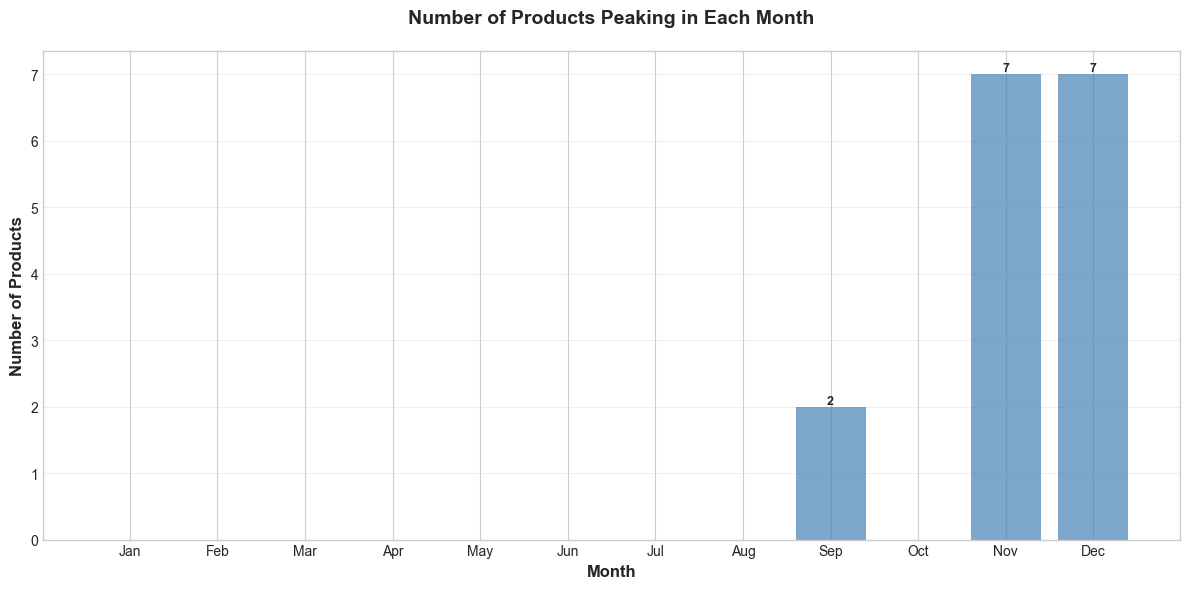

📊 Chart shows: Which months are peak months for most products
   Insight: Nov is the most common peak month (7 products)
   Plan product launches and marketing campaigns around peak months


In [59]:
if len(seasonal_analysis_df) > 0:
    # Visualization 2: Best Month Distribution
    fig, ax = plt.subplots(figsize=(12, 6))
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    best_month_counts = seasonal_analysis_df['best_month'].value_counts().sort_index()
    bars = ax.bar(range(1, 13), [best_month_counts.get(i, 0) for i in range(1, 13)], color='steelblue', alpha=0.7)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names)
    ax.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
    ax.set_title('Number of Products Peaking in Each Month', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, month in enumerate(range(1, 13)):
        count = best_month_counts.get(month, 0)
        if count > 0:
            ax.text(i+1, count, str(count), ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    best_month = best_month_counts.idxmax()
    print(f"📊 Chart shows: Which months are peak months for most products")
    print(f"   Insight: {month_names[int(best_month)-1]} is the most common peak month ({best_month_counts[best_month]} products)")
    print("   Plan product launches and marketing campaigns around peak months")
else:
    print("⚠ No data available for visualization")


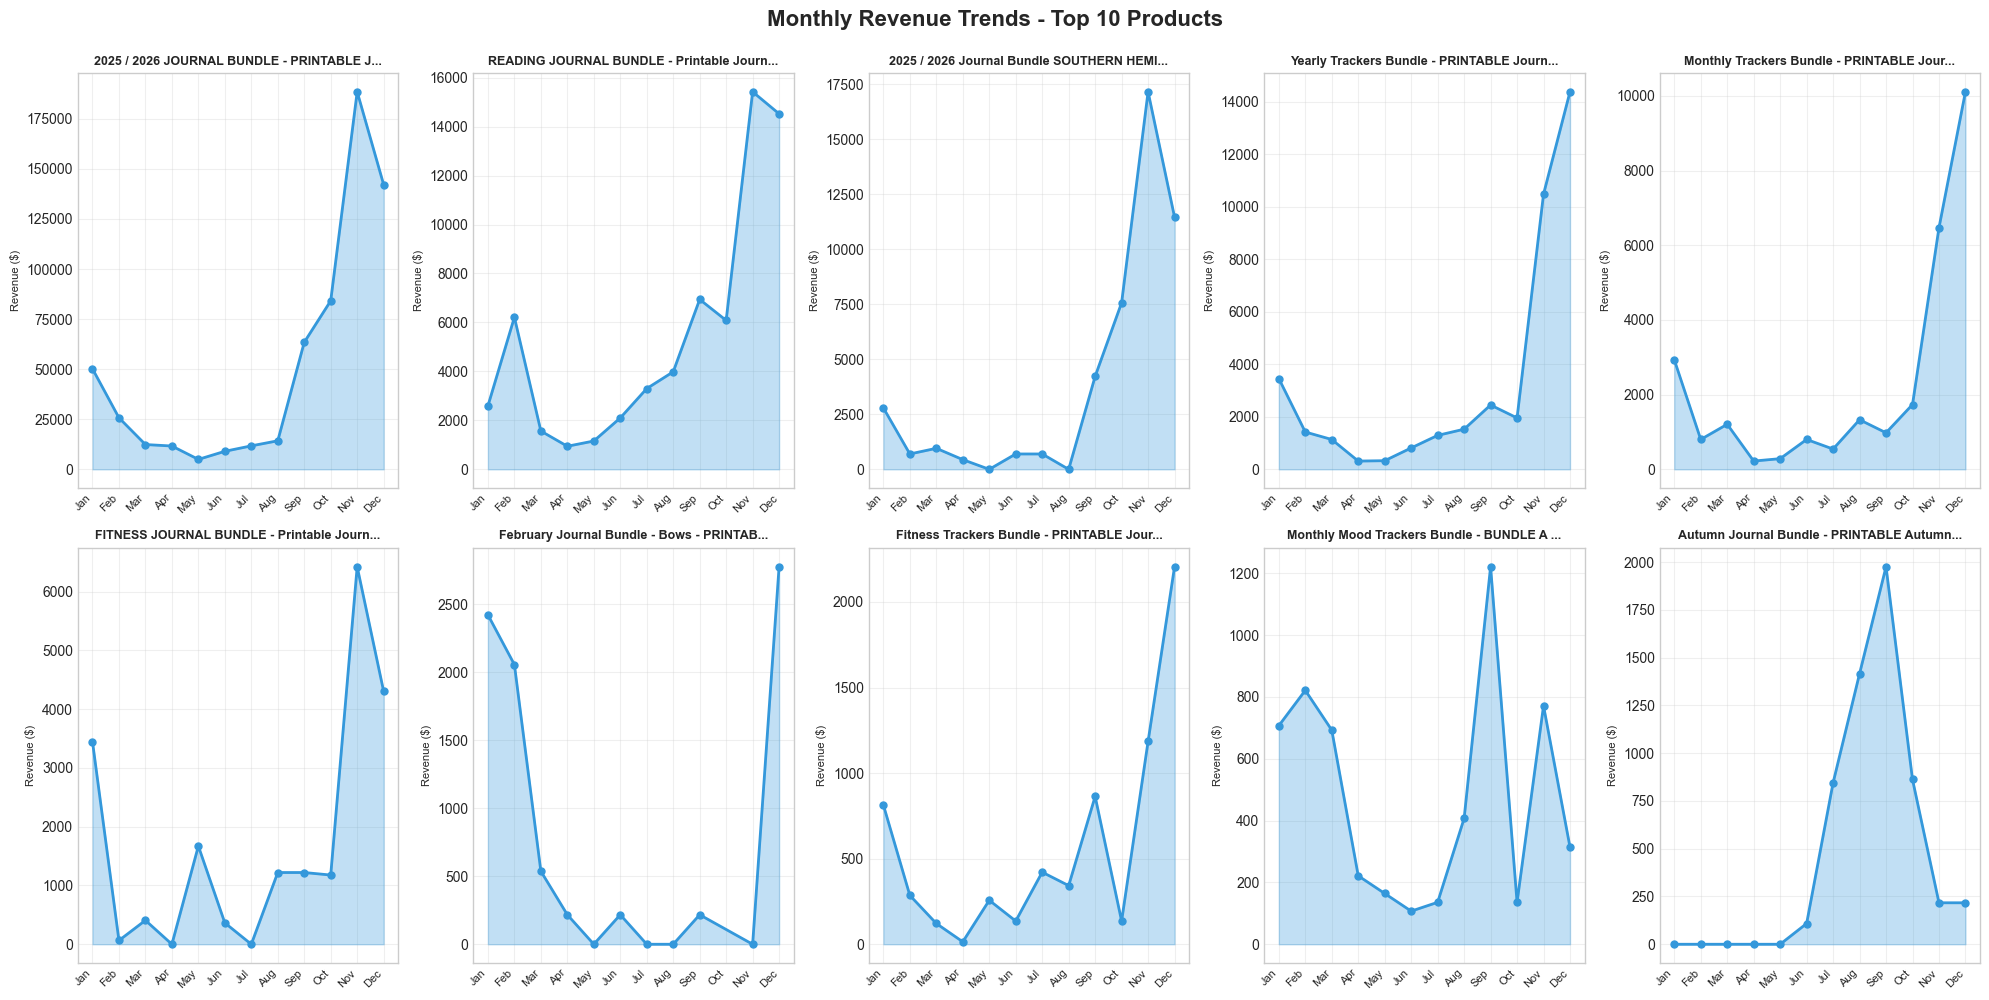

📊 Chart shows: Monthly revenue patterns for top 10 products
   Insight: Each product has unique seasonal patterns
   Use these patterns to optimize inventory and marketing timing


In [60]:
if len(trends_df) > 0:
    # Visualization 3: Top 10 Products - Monthly Revenue Trends
    top_10_products = seasonal_analysis_df.nlargest(10, 'total_revenue')
    top_10_ids = top_10_products['listing_id'].values
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for idx, listing_id in enumerate(top_10_ids):
        if idx >= 10:
            break
        
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_title = product_trends['title'].iloc[0]
        
        monthly_revenue = product_trends.groupby('month')['total_revenue'].sum().sort_index()
        
        ax = axes[idx]
        ax.plot(monthly_revenue.index, monthly_revenue.values, marker='o', linewidth=2, markersize=5, color='#3498db')
        ax.fill_between(monthly_revenue.index, monthly_revenue.values, alpha=0.3, color='#3498db')
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(month_names, rotation=45, ha='right', fontsize=8)
        ax.set_title(product_title[:40] + '...' if len(product_title) > 40 else product_title, fontsize=9, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.set_ylabel('Revenue ($)', fontsize=8)
    
    plt.suptitle('Monthly Revenue Trends - Top 10 Products', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("📊 Chart shows: Monthly revenue patterns for top 10 products")
    print("   Insight: Each product has unique seasonal patterns")
    print("   Use these patterns to optimize inventory and marketing timing")
else:
    print("⚠ No data available for visualization")


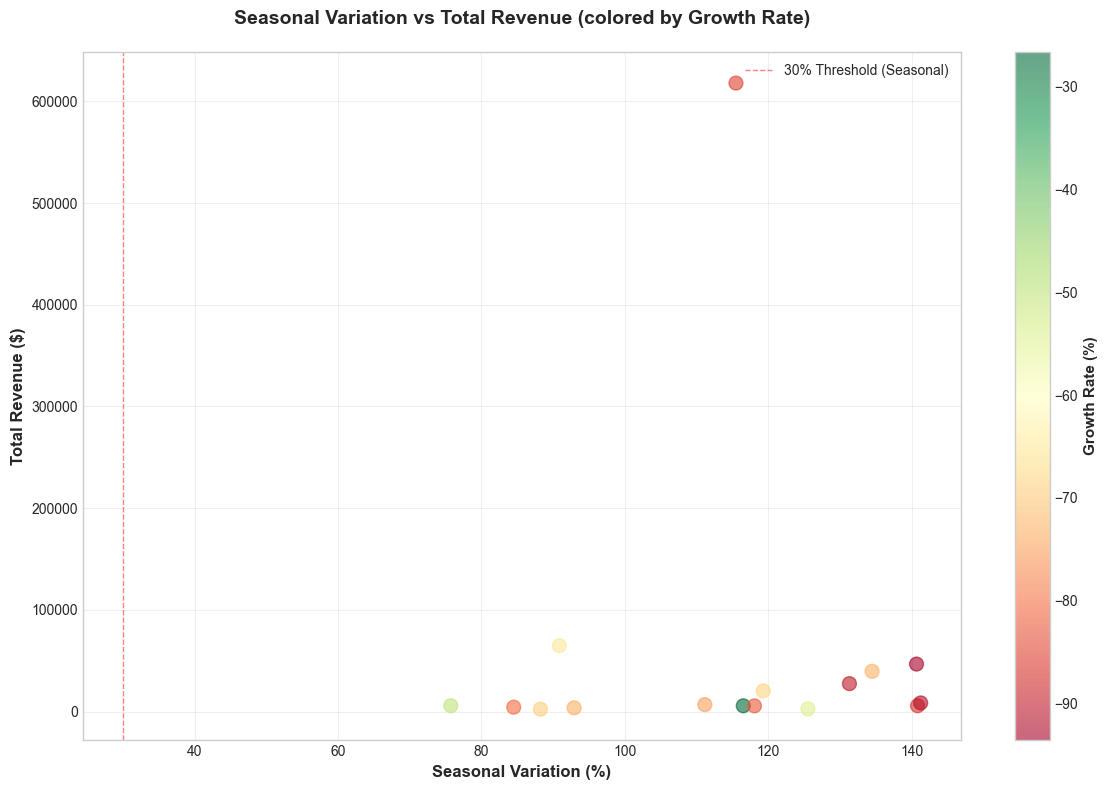

📊 Chart shows: Relationship between seasonal variation and revenue
   Insight: Products to the right of red line are highly seasonal
   Color indicates growth - green = growing, red = declining
   High revenue + low variation = stable cash cows


In [61]:
if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    # Calculate actual total revenue from trends data for each product
    actual_revenue = trends_df.groupby('listing_id').agg({
        'total_revenue': 'sum'
    }).reset_index()
    actual_revenue.columns = ['listing_id', 'actual_total_revenue']
    
    # Merge with seasonal_analysis_df
    revenue_with_info = seasonal_analysis_df.merge(actual_revenue, on='listing_id', how='left')
    revenue_with_info['actual_total_revenue'] = revenue_with_info['actual_total_revenue'].fillna(0)
    
    # Visualization 4: Seasonal Variation vs Total Revenue
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(revenue_with_info['seasonal_variation'], 
                         revenue_with_info['actual_total_revenue'],
                         c=revenue_with_info['growth_rate'], 
                         s=100, alpha=0.6, cmap='RdYlGn')
    ax.set_xlabel('Seasonal Variation (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
    ax.set_title('Seasonal Variation vs Total Revenue (colored by Growth Rate)', fontsize=14, fontweight='bold', pad=20)
    ax.grid(alpha=0.3)
    
    # Add threshold line
    ax.axvline(30, color='red', linestyle='--', linewidth=1, alpha=0.5, label='30% Threshold (Seasonal)')
    ax.legend()
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Growth Rate (%)', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Chart shows: Relationship between seasonal variation and revenue")
    print("   Insight: Products to the right of red line are highly seasonal")
    print("   Color indicates growth - green = growing, red = declining")
    print("   High revenue + low variation = stable cash cows")
else:
    print("⚠ No data available for visualization")


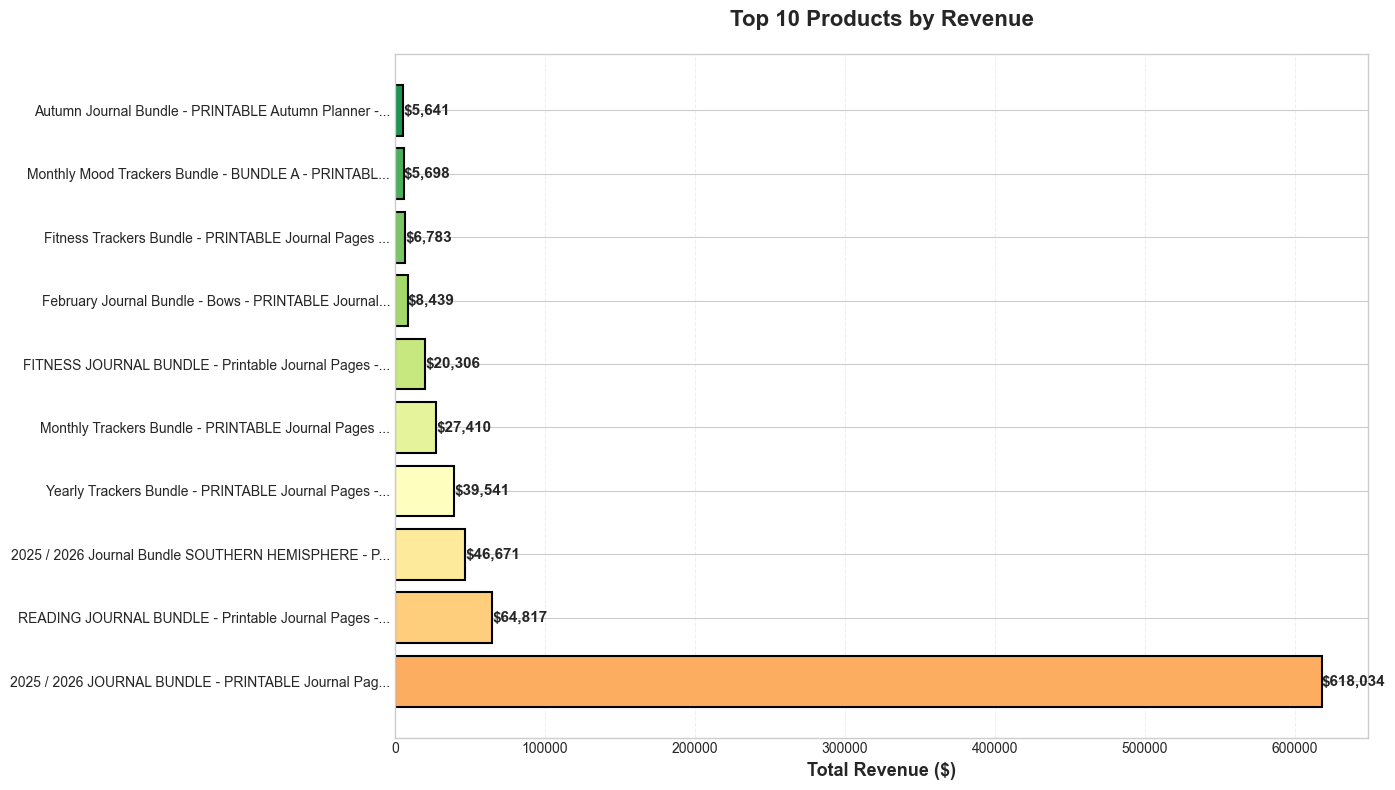


✅ Top Revenue Products
   • Top product: 2025 / 2026 JOURNAL BUNDLE - PRINTABLE Journal Pages - Digit
   • Top 10 products generate: $843,342
   • This represents 97.2% of total revenue


In [62]:
# Visualization 3: Top 10 Products by Revenue
if len(seasonal_analysis_df) > 0:
    top_10 = seasonal_analysis_df.nlargest(10, 'total_revenue')
    
    fig, ax = plt.subplots(figsize=(14, 8))
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_10)))
    bars = ax.barh(range(len(top_10)), top_10['total_revenue'].values, color=colors, edgecolor='black', linewidth=1.5)
    
    titles = [title[:50] + '...' if len(title) > 50 else title for title in top_10['title'].values]
    ax.set_yticks(range(len(top_10)))
    ax.set_yticklabels(titles, fontsize=10)
    ax.set_xlabel('Total Revenue ($)', fontsize=13, fontweight='bold')
    ax.set_title('Top 10 Products by Revenue', fontsize=16, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    for i, (bar, value) in enumerate(zip(bars, top_10['total_revenue'].values)):
        ax.text(value, bar.get_y() + bar.get_height()/2,
                f'${value:,.0f}', ha='left', va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    total_revenue_all = seasonal_analysis_df['total_revenue'].sum()
    print(f"\n✅ Top Revenue Products")
    print(f"   • Top product: {top_10.iloc[0]['title'][:60]}")
    print(f"   • Top 10 products generate: ${top_10['total_revenue'].sum():,.0f}")
    print(f"   • This represents {top_10['total_revenue'].sum()/total_revenue_all*100:.1f}% of total revenue")
else:
    print("⚠ No data available for visualization")


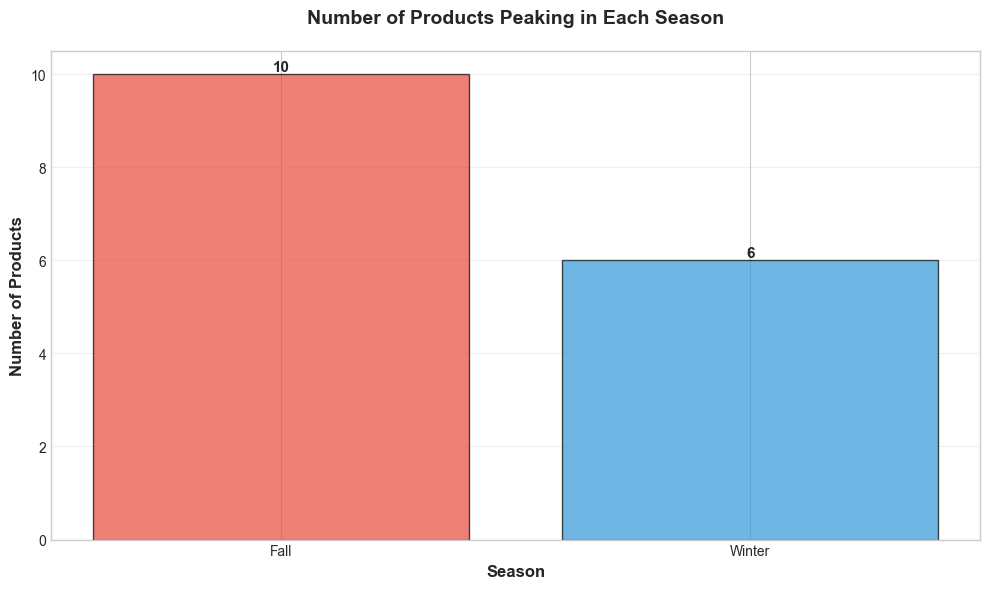

📊 Chart shows: Which season is peak season for most products
   Insight: Fall is the most common peak season (10 products)
   Plan inventory and marketing around peak seasons


In [63]:
if len(seasonal_analysis_df) > 0:
    # Visualization 5: Best Season Distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    seasonal_counts = seasonal_analysis_df['best_season'].value_counts()
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
    bars = ax.bar(seasonal_counts.index, seasonal_counts.values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Season', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
    ax.set_title('Number of Products Peaking in Each Season', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (season, count) in enumerate(seasonal_counts.items()):
        ax.text(i, count, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    best_season = seasonal_counts.idxmax()
    print(f"📊 Chart shows: Which season is peak season for most products")
    print(f"   Insight: {best_season} is the most common peak season ({seasonal_counts[best_season]} products)")
    print("   Plan inventory and marketing around peak seasons")
else:
    print("⚠ No data available for visualization")


In [64]:
# Export all new insights to CSV
if len(seasonal_analysis_df) > 0:
    os.makedirs('csv_exports/bundle_paper_analysis', exist_ok=True)
    
    exported_insights = []
    
    # Export revenue concentration
    if 'concentration_df' in globals() and len(concentration_df) > 0:
        try:
            concentration_df.to_csv('csv_exports/bundle_paper_analysis/revenue_concentration_analysis.csv', 
                                     index=False, encoding='utf-8')
            exported_insights.append('revenue_concentration_analysis.csv')
            print("✓ Exported: revenue_concentration_analysis.csv")
        except:
            pass
    
    # Export holiday impact
    if 'holiday_df' in globals() and len(holiday_df) > 0:
        try:
            holiday_df.to_csv('csv_exports/bundle_paper_analysis/holiday_impact_analysis.csv', 
                              index=False, encoding='utf-8')
            exported_insights.append('holiday_impact_analysis.csv')
            print("✓ Exported: holiday_impact_analysis.csv")
        except:
            pass
    
    # Export quarterly performance
    if 'quarterly_df' in globals() and len(quarterly_df) > 0:
        try:
            quarterly_df.to_csv('csv_exports/bundle_paper_analysis/quarterly_performance_analysis.csv', 
                                index=False, encoding='utf-8')
            exported_insights.append('quarterly_performance_analysis.csv')
            print("✓ Exported: quarterly_performance_analysis.csv")
        except:
            pass
    
    # Export peak duration analysis
    if 'peak_duration_df' in globals() and len(peak_duration_df) > 0:
        try:
            peak_duration_df.to_csv('csv_exports/bundle_paper_analysis/peak_duration_recovery_analysis.csv', 
                                     index=False, encoding='utf-8')
            exported_insights.append('peak_duration_recovery_analysis.csv')
            print("✓ Exported: peak_duration_recovery_analysis.csv")
        except:
            pass
    
    # Export optimal launch timing
    if 'monthly_performance' in globals() and len(monthly_performance) > 0:
        try:
            monthly_performance.to_csv('csv_exports/bundle_paper_analysis/optimal_launch_timing.csv', 
                                       index=False, encoding='utf-8')
            exported_insights.append('optimal_launch_timing.csv')
            print("✓ Exported: optimal_launch_timing.csv")
        except:
            pass
    
    if len(exported_insights) > 0:
        print(f"\n✅ Exported {len(exported_insights)} additional insight files")
    else:
        print("\n⚠ No additional insights to export")


✓ Exported: revenue_concentration_analysis.csv
✓ Exported: holiday_impact_analysis.csv
✓ Exported: quarterly_performance_analysis.csv
✓ Exported: peak_duration_recovery_analysis.csv
✓ Exported: optimal_launch_timing.csv

✅ Exported 5 additional insight files


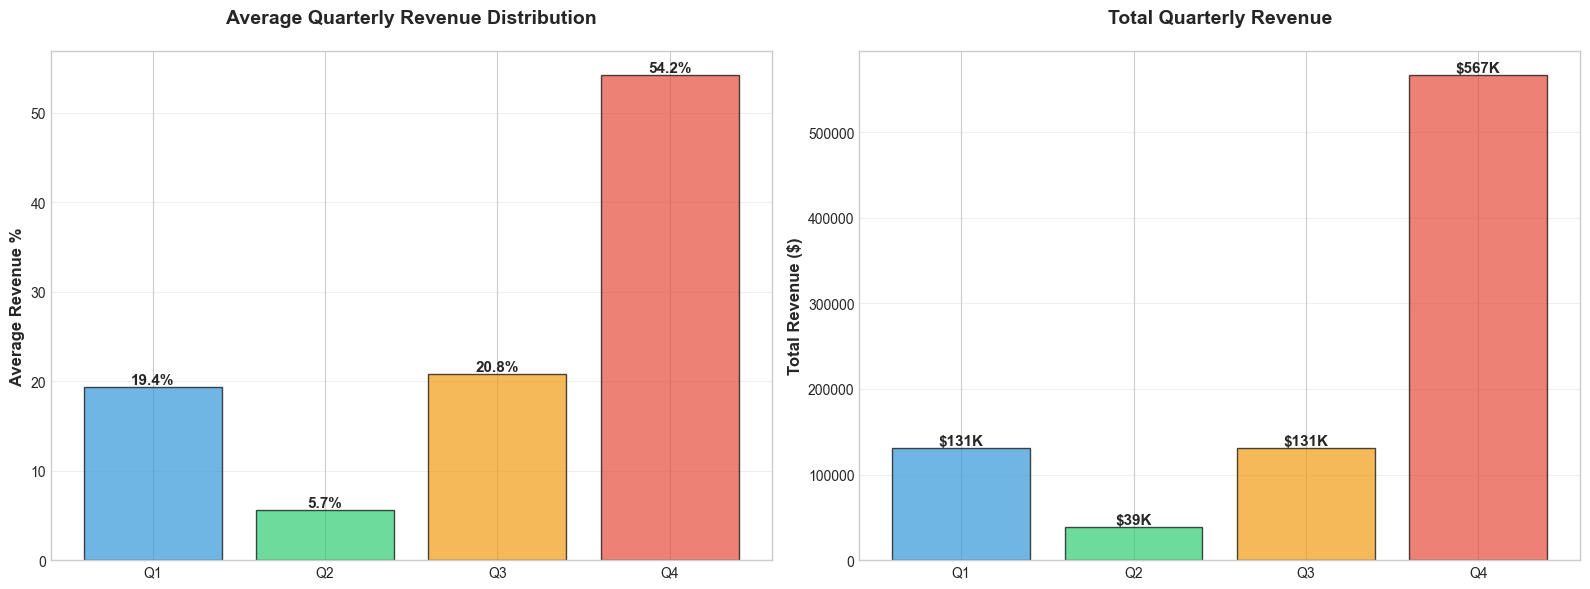

📊 Chart shows: Quarterly revenue distribution patterns
   Insight: Q4 generates 54.2% of revenue on average
   Plan inventory and marketing budgets by quarter


In [65]:
# Additional Visualization: Quarterly Revenue Distribution
if 'quarterly_df' in globals() and len(quarterly_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Chart 1: Average quarterly distribution
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']
    avg_pct = [
        quarterly_df['q1_pct'].mean(),
        quarterly_df['q2_pct'].mean(),
        quarterly_df['q3_pct'].mean(),
        quarterly_df['q4_pct'].mean()
    ]
    
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
    bars1 = ax1.bar(quarters, avg_pct, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Average Revenue %', fontsize=12, fontweight='bold')
    ax1.set_title('Average Quarterly Revenue Distribution', fontsize=14, fontweight='bold', pad=20)
    ax1.grid(axis='y', alpha=0.3)
    
    for i, (bar, pct) in enumerate(zip(bars1, avg_pct)):
        ax1.text(bar.get_x() + bar.get_width()/2., pct,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Chart 2: Total quarterly revenue
    total_revenue = [
        quarterly_df['q1_revenue'].sum(),
        quarterly_df['q2_revenue'].sum(),
        quarterly_df['q3_revenue'].sum(),
        quarterly_df['q4_revenue'].sum()
    ]
    
    bars2 = ax2.bar(quarters, total_revenue, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
    ax2.set_title('Total Quarterly Revenue', fontsize=14, fontweight='bold', pad=20)
    ax2.grid(axis='y', alpha=0.3)
    
    for i, (bar, rev) in enumerate(zip(bars2, total_revenue)):
        ax2.text(bar.get_x() + bar.get_width()/2., rev,
                f'${rev/1000:.0f}K', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Chart shows: Quarterly revenue distribution patterns")
    print(f"   Insight: Q4 generates {quarterly_df['q4_pct'].mean():.1f}% of revenue on average")
    print("   Plan inventory and marketing budgets by quarter")
else:
    print("⚠ No quarterly data available for visualization")


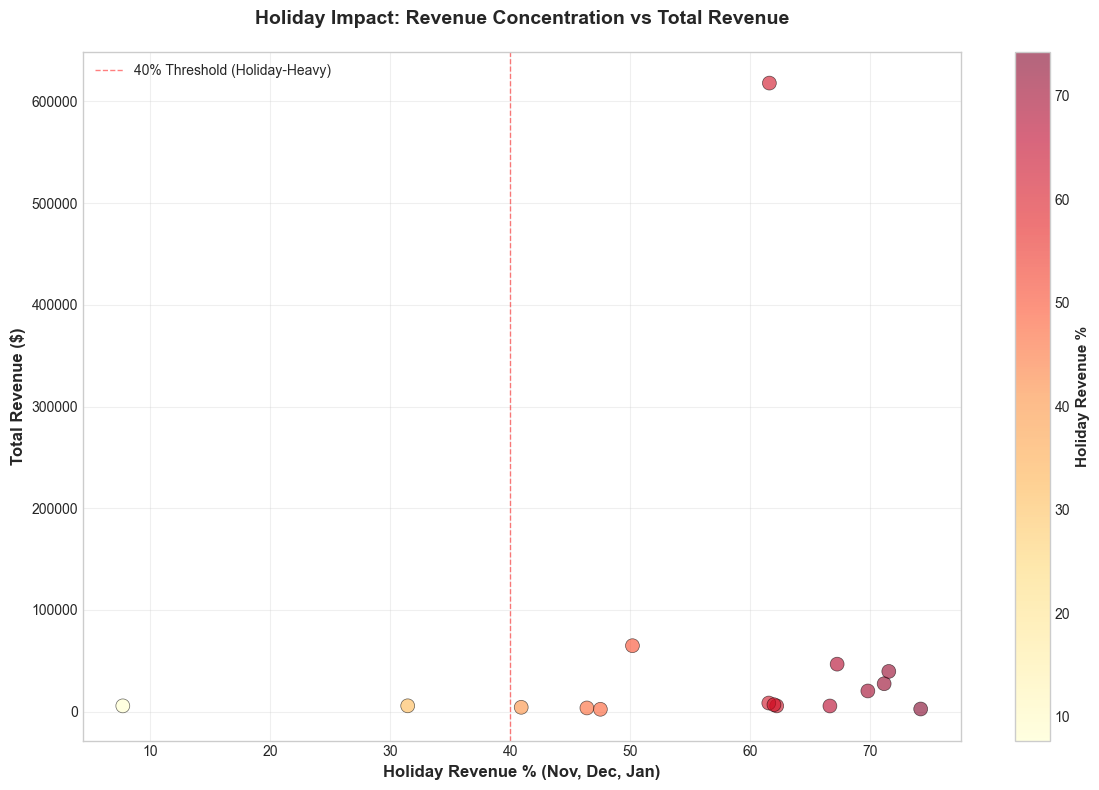

📊 Chart shows: Relationship between holiday revenue concentration and total revenue
   Insight: 14 products are holiday-heavy (>40% in holidays)
   Products above red line need aggressive Q4 marketing


In [66]:
# Additional Visualization: Holiday Impact
if 'holiday_df' in globals() and len(holiday_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Scatter plot: Holiday revenue % vs Total revenue
    scatter = ax.scatter(holiday_df['holiday_revenue_pct'], 
                         holiday_df['total_revenue'],
                         s=100, alpha=0.6, c=holiday_df['holiday_revenue_pct'],
                         cmap='YlOrRd', edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('Holiday Revenue % (Nov, Dec, Jan)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
    ax.set_title('Holiday Impact: Revenue Concentration vs Total Revenue', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(alpha=0.3)
    
    # Add threshold line
    ax.axvline(40, color='red', linestyle='--', linewidth=1, alpha=0.5, 
               label='40% Threshold (Holiday-Heavy)')
    ax.legend()
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Holiday Revenue %', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    holiday_heavy_count = len(holiday_df[holiday_df['holiday_revenue_pct'] > 40])
    print("📊 Chart shows: Relationship between holiday revenue concentration and total revenue")
    print(f"   Insight: {holiday_heavy_count} products are holiday-heavy (>40% in holidays)")
    print("   Products above red line need aggressive Q4 marketing")
else:
    print("⚠ No holiday impact data available for visualization")


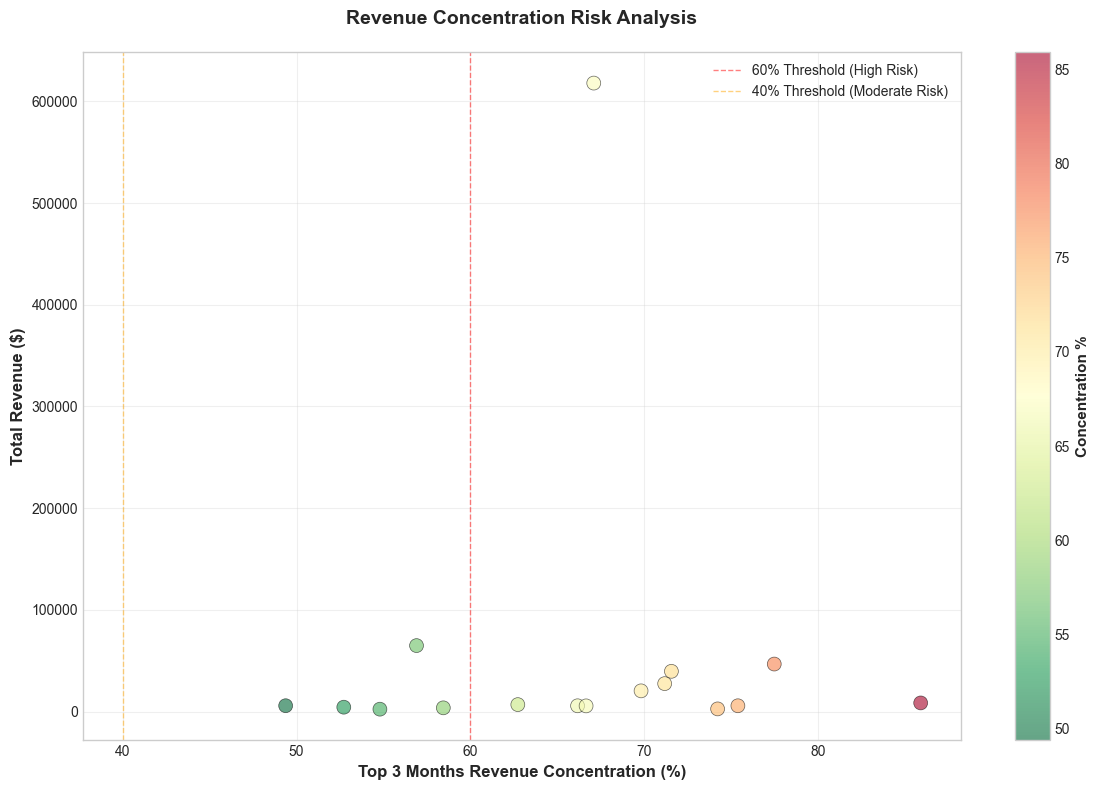

📊 Chart shows: Revenue concentration risk vs total revenue
   Insight: 11 products have high concentration risk (>60% in top 3 months)
   Red zone = high risk, Green zone = well-distributed revenue


In [67]:
# Additional Visualization: Revenue Concentration Risk
if 'concentration_df' in globals() and len(concentration_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Scatter plot: Top 3 months concentration vs Total revenue
    scatter = ax.scatter(concentration_df['top_3_concentration_pct'], 
                         concentration_df['total_revenue'],
                         s=100, alpha=0.6, c=concentration_df['top_3_concentration_pct'],
                         cmap='RdYlGn_r', edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('Top 3 Months Revenue Concentration (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
    ax.set_title('Revenue Concentration Risk Analysis', fontsize=14, fontweight='bold', pad=20)
    ax.grid(alpha=0.3)
    
    # Add threshold lines
    ax.axvline(60, color='red', linestyle='--', linewidth=1, alpha=0.5, 
               label='60% Threshold (High Risk)')
    ax.axvline(40, color='orange', linestyle='--', linewidth=1, alpha=0.5, 
               label='40% Threshold (Moderate Risk)')
    ax.legend()
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Concentration %', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    high_risk = len(concentration_df[concentration_df['top_3_concentration_pct'] > 60])
    print("📊 Chart shows: Revenue concentration risk vs total revenue")
    print(f"   Insight: {high_risk} products have high concentration risk (>60% in top 3 months)")
    print("   Red zone = high risk, Green zone = well-distributed revenue")
else:
    print("⚠ No concentration data available for visualization")


## Step 9: Comprehensive Insights Summary


In [68]:
# Comprehensive Summary of All Insights
if len(seasonal_analysis_df) > 0:
    print("="*80)
    print("COMPREHENSIVE SEASONAL INSIGHTS SUMMARY")
    print("="*80)
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    print("\n📊 PORTFOLIO OVERVIEW:")
    print(f"  • Total Products: {len(seasonal_analysis_df)}")
    print(f"  • Total Revenue: ${seasonal_analysis_df['total_revenue'].sum():,.2f}")
    print(f"  • Average Revenue per Product: ${seasonal_analysis_df['total_revenue'].mean():,.2f}")
    print(f"  • Seasonal Products: {seasonal_analysis_df['is_seasonal'].sum()} ({seasonal_analysis_df['is_seasonal'].sum()/len(seasonal_analysis_df)*100:.1f}%)")
    
    print("\n📅 TIMING INSIGHTS:")
    best_month = seasonal_analysis_df['best_month'].mode()[0] if len(seasonal_analysis_df['best_month'].mode()) > 0 else None
    best_season = seasonal_analysis_df['best_season'].mode()[0] if len(seasonal_analysis_df['best_season'].mode()) > 0 else None
    if best_month:
        print(f"  • Most Common Peak Month: {month_names[int(best_month)-1]} ({seasonal_analysis_df['best_month'].value_counts()[best_month]} products)")
    if best_season:
        print(f"  • Most Common Peak Season: {best_season} ({seasonal_analysis_df['best_season'].value_counts()[best_season]} products)")
    
    if 'quarterly_df' in globals() and len(quarterly_df) > 0:
        best_q = quarterly_df['best_quarter'].value_counts().idxmax()
        print(f"  • Best Quarter: {best_q} ({quarterly_df['best_quarter'].value_counts()[best_q]} products)")
    
    print("\n💰 REVENUE INSIGHTS:")
    if 'concentration_df' in globals() and len(concentration_df) > 0:
        print(f"  • Average Top 3 Months Concentration: {concentration_df['top_3_concentration_pct'].mean():.1f}%")
        high_risk = len(concentration_df[concentration_df['top_3_concentration_pct'] > 60])
        print(f"  • High-Risk Products (>60% concentration): {high_risk}")
    
    if 'holiday_df' in globals() and len(holiday_df) > 0:
        holiday_avg = holiday_df['holiday_revenue_pct'].mean()
        print(f"  • Average Holiday Revenue: {holiday_avg:.1f}% of annual revenue")
        holiday_heavy = len(holiday_df[holiday_df['holiday_revenue_pct'] > 40])
        print(f"  • Holiday-Heavy Products: {holiday_heavy}")
    
    print("\n📈 GROWTH INSIGHTS:")
    growing = len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] > 0])
    declining = len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] < 0])
    print(f"  • Growing Products: {growing} ({growing/len(seasonal_analysis_df)*100:.1f}%)")
    print(f"  • Declining Products: {declining} ({declining/len(seasonal_analysis_df)*100:.1f}%)")
    print(f"  • Average Growth Rate: {seasonal_analysis_df['growth_rate'].mean():.1f}%")
    
    print("\n⚡ PERFORMANCE INSIGHTS:")
    if 'peak_duration_df' in globals() and len(peak_duration_df) > 0:
        print(f"  • Average Peak Duration: {peak_duration_df['peak_duration_months'].mean():.1f} months")
        print(f"  • Average Recovery Time: {peak_duration_df['recovery_time_months'].mean():.1f} months")
    
    print("\n🎯 KEY RECOMMENDATIONS:")
    print("  1. INVENTORY: Plan 2-3 months before peak months/seasons")
    print("  2. MARKETING: Focus on Q4 and holiday-heavy products")
    print("  3. RISK: Diversify products with high revenue concentration")
    print("  4. GROWTH: Invest in growing products, optimize declining ones")
    print("  5. TIMING: Launch new products in high-performing months")
    
    print("\n" + "="*80)


COMPREHENSIVE SEASONAL INSIGHTS SUMMARY

📊 PORTFOLIO OVERVIEW:
  • Total Products: 16
  • Total Revenue: $867,229.35
  • Average Revenue per Product: $54,201.83
  • Seasonal Products: 16 (100.0%)

📅 TIMING INSIGHTS:
  • Most Common Peak Month: Nov (7 products)
  • Most Common Peak Season: Fall (10 products)
  • Best Quarter: Q4 (13 products)

💰 REVENUE INSIGHTS:
  • Average Top 3 Months Concentration: 66.3%
  • High-Risk Products (>60% concentration): 11
  • Average Holiday Revenue: 55.8% of annual revenue
  • Holiday-Heavy Products: 14

📈 GROWTH INSIGHTS:
  • Growing Products: 0 (0.0%)
  • Declining Products: 16 (100.0%)
  • Average Growth Rate: -72.8%

⚡ PERFORMANCE INSIGHTS:
  • Average Peak Duration: 3.6 months
  • Average Recovery Time: 7.1 months

🎯 KEY RECOMMENDATIONS:
  1. INVENTORY: Plan 2-3 months before peak months/seasons
  2. MARKETING: Focus on Q4 and holiday-heavy products
  3. RISK: Diversify products with high revenue concentration
  4. GROWTH: Invest in growing produc

## Step 8: Export Analysis Results


In [69]:
# Create export folder for bundle paper analysis
os.makedirs('csv_exports/bundle_paper_analysis', exist_ok=True)

# Export seasonal analysis (sorted by total_sales descending)
if len(seasonal_analysis_df) > 0:
    # Sort by total_sales from largest to smallest
    seasonal_analysis_sorted = seasonal_analysis_df.sort_values('total_sales', ascending=False)
    seasonal_analysis_sorted.to_csv('csv_exports/bundle_paper_analysis/bundle_paper_seasonal_analysis.csv', index=False, encoding='utf-8')
    print("✓ Exported: bundle_paper_seasonal_analysis.csv (sorted by total_sales, largest to smallest)")
    
    # Export detailed trends
    if len(trends_df) > 0:
        trends_df.to_csv('csv_exports/bundle_paper_analysis/bundle_paper_trends_detailed.csv', index=False, encoding='utf-8')
        print("✓ Exported: bundle_paper_trends_detailed.csv")
    
    print("\n" + "="*70)
    print("BUNDLE PAPER SEASONAL ANALYSIS SUMMARY")
    print("="*70)
    
    # Top seasonal products
    top_seasonal = seasonal_analysis_df.nlargest(10, 'seasonal_variation')
    print(f"\n📈 TOP 10 MOST SEASONAL PRODUCTS (Highest Variation):")
    for idx, row in top_seasonal.iterrows():
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        print(f"  • {row['title'][:60]}")
        print(f"    Variation: {row['seasonal_variation']:.1f}% | Best Month: {month_names[int(row['best_month'])-1]} | Best Season: {row['best_season']}")
    
    print(f"\n💡 Insight: These products show strong seasonal patterns - plan inventory and marketing accordingly")


✓ Exported: bundle_paper_seasonal_analysis.csv (sorted by total_sales, largest to smallest)
✓ Exported: bundle_paper_trends_detailed.csv

BUNDLE PAPER SEASONAL ANALYSIS SUMMARY

📈 TOP 10 MOST SEASONAL PRODUCTS (Highest Variation):
  • February Journal Bundle - Bows - PRINTABLE Journal Pages - P
    Variation: 141.2% | Best Month: Dec | Best Season: Winter
  • Autumn Journal Bundle - PRINTABLE Autumn Planner - 17 Journa
    Variation: 140.8% | Best Month: Sep | Best Season: Fall
  • 2025 / 2026 Journal Bundle SOUTHERN HEMISPHERE - PRINTABLE J
    Variation: 140.7% | Best Month: Nov | Best Season: Fall
  • Yearly Trackers Bundle - PRINTABLE Journal Pages - Digital P
    Variation: 134.5% | Best Month: Dec | Best Season: Winter
  • Monthly Trackers Bundle - PRINTABLE Journal Pages - Digital 
    Variation: 131.3% | Best Month: Dec | Best Season: Winter
  • Things to Remember Bundle - A5 Journal Page - Printable Jour
    Variation: 125.5% | Best Month: Dec | Best Season: Winter
  • FITNESS

## Step 9: Export Comprehensive PDF Report


In [70]:
# Export Comprehensive PDF Summary Report with All Insights and Visualizations
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime

print("="*80)
print("GENERATING COMPREHENSIVE PDF REPORT")
print("="*80)

if len(seasonal_analysis_df) > 0:
    # Create PDF exports folder if it doesn't exist
    os.makedirs('pdf_exports', exist_ok=True)
    
    pdf_filename = f'pdf_exports/bundle_paper_seasonal_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pdf'
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    with PdfPages(pdf_filename) as pdf:
        # Page 1: Executive Summary
        fig = plt.figure(figsize=(11, 8.5))
        fig.text(0.5, 0.95, 'BUNDLE PAPER SEASONAL ANALYSIS', 
                ha='center', va='top', fontsize=22, fontweight='bold')
        fig.text(0.5, 0.91, f'Comprehensive Report - Generated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}', 
                ha='center', va='top', fontsize=11, style='italic')
        
        # Key Metrics
        y_pos = 0.85
        fig.text(0.1, y_pos, 'EXECUTIVE SUMMARY', fontsize=16, fontweight='bold')
        y_pos -= 0.08
        
        total_products = len(seasonal_analysis_df)
        
        # Calculate actual revenue from trends data
        if len(trends_df) > 0:
            actual_revenue = trends_df.groupby('listing_id')['total_revenue'].sum().reset_index()
            actual_revenue.columns = ['listing_id', 'actual_total_revenue']
            revenue_with_info = seasonal_analysis_df.merge(actual_revenue, on='listing_id', how='left')
            revenue_with_info['actual_total_revenue'] = revenue_with_info['actual_total_revenue'].fillna(0)
            total_revenue = revenue_with_info['actual_total_revenue'].sum()
            avg_revenue = revenue_with_info['actual_total_revenue'].mean()
        else:
            total_revenue = seasonal_analysis_df['total_revenue'].sum()
            avg_revenue = seasonal_analysis_df['total_revenue'].mean()
            revenue_with_info = seasonal_analysis_df.copy()
            revenue_with_info['actual_total_revenue'] = revenue_with_info['total_revenue']
        seasonal_count = seasonal_analysis_df['is_seasonal'].sum()
        seasonal_pct = (seasonal_count / total_products * 100) if total_products > 0 else 0
        
        fig.text(0.15, y_pos, f'• Total Products Analyzed: {total_products}', fontsize=12)
        y_pos -= 0.06
        fig.text(0.15, y_pos, f'• Total Revenue: ${total_revenue:,.2f}', fontsize=12)
        y_pos -= 0.06
        fig.text(0.15, y_pos, f'• Average Revenue per Product: ${avg_revenue:,.2f}', fontsize=12)
        y_pos -= 0.06
        fig.text(0.15, y_pos, f'• Seasonal Products: {seasonal_count} ({seasonal_pct:.1f}%)', fontsize=12)
        y_pos -= 0.06
        fig.text(0.15, y_pos, f'• Stable Products: {total_products - seasonal_count} ({100-seasonal_pct:.1f}%)', fontsize=12)
        y_pos -= 0.08
        
        # Top Products
        if len(seasonal_analysis_df) > 0:
            fig.text(0.1, y_pos, 'TOP 5 PRODUCTS BY REVENUE:', fontsize=14, fontweight='bold')
            y_pos -= 0.08
            top_5 = revenue_with_info.nlargest(5, 'actual_total_revenue')
            for idx, (i, row) in enumerate(top_5.iterrows()):
                title = row['title'][:60] + '...' if len(row['title']) > 60 else row['title']
                fig.text(0.15, y_pos, f'{idx+1}. {title}', fontsize=10)
                fig.text(0.15, y_pos-0.04, f'   Revenue: ${row.get("actual_total_revenue", row.get("total_revenue", 0)):,.2f} | Best Month: {month_names[int(row["best_month"])-1]}', 
                        fontsize=9, style='italic')
                y_pos -= 0.08
        
        # Best Month/Season
        if len(seasonal_analysis_df) > 0:
            best_month = seasonal_analysis_df['best_month'].mode()[0] if len(seasonal_analysis_df['best_month'].mode()) > 0 else None
            best_season = seasonal_analysis_df['best_season'].mode()[0] if len(seasonal_analysis_df['best_season'].mode()) > 0 else None
            y_pos -= 0.05
            fig.text(0.1, y_pos, 'PEAK TIMING INSIGHTS:', fontsize=14, fontweight='bold')
            y_pos -= 0.06
            if best_month:
                month_name = month_names[int(best_month)-1]
                count = seasonal_analysis_df['best_month'].value_counts()[best_month]
                fig.text(0.15, y_pos, f'• Most Common Peak Month: {month_name} ({count} products)', fontsize=11)
                y_pos -= 0.05
            if best_season:
                count = seasonal_analysis_df['best_season'].value_counts()[best_season]
                fig.text(0.15, y_pos, f'• Most Common Peak Season: {best_season} ({count} products)', fontsize=11)
        
        plt.axis('off')
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
        
        # Page 2: Revenue Concentration Analysis
        if 'concentration_df' in globals() and len(concentration_df) > 0:
            fig = plt.figure(figsize=(11, 8.5))
            fig.text(0.5, 0.95, 'REVENUE CONCENTRATION ANALYSIS', 
                    ha='center', va='top', fontsize=18, fontweight='bold')
            
            y_pos = 0.88
            avg_concentration = concentration_df['top_3_concentration_pct'].mean()
            high_risk = len(concentration_df[concentration_df['top_3_concentration_pct'] > 60])
            
            fig.text(0.1, y_pos, 'KEY INSIGHTS:', fontsize=14, fontweight='bold')
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Average Top 3 Months Concentration: {avg_concentration:.1f}%', fontsize=11)
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• High-Risk Products (>60% concentration): {high_risk}', fontsize=11)
            y_pos -= 0.08
            
            # Top 5 High Concentration Products
            high_concentration = concentration_df[concentration_df['top_3_concentration_pct'] > 60].nlargest(5, 'total_revenue')
            if len(high_concentration) > 0:
                fig.text(0.1, y_pos, 'HIGH-RISK PRODUCTS:', fontsize=12, fontweight='bold')
                y_pos -= 0.06
                for idx, (i, row) in enumerate(high_concentration.iterrows()):
                    title = row['title'][:55] + '...' if len(row['title']) > 55 else row['title']
                    fig.text(0.15, y_pos, f'{idx+1}. {title}', fontsize=10)
                    fig.text(0.15, y_pos-0.04, f'   Concentration: {row["top_3_concentration_pct"]:.1f}% | Revenue: ${row["total_revenue"]:,.2f}', 
                            fontsize=9, style='italic')
                    y_pos -= 0.08
            
            # Visualization - positioned at bottom to avoid text overlap
            ax = fig.add_axes([0.1, 0.05, 0.8, 0.35])
            scatter = ax.scatter(concentration_df['top_3_concentration_pct'], 
                               concentration_df['total_revenue'],
                               s=100, alpha=0.6, c=concentration_df['top_3_concentration_pct'],
                               cmap='RdYlGn_r', edgecolors='black', linewidth=0.5)
            ax.set_xlabel('Top 3 Months Revenue Concentration (%)', fontsize=10, fontweight='bold')
            ax.set_ylabel('Total Revenue ($)', fontsize=10, fontweight='bold')
            ax.set_title('Revenue Concentration Risk Analysis', fontsize=11, fontweight='bold')
            ax.grid(alpha=0.3)
            ax.axvline(60, color='red', linestyle='--', linewidth=1, alpha=0.5, label='60% Threshold (High Risk)')
            ax.legend(fontsize=9)
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Concentration %', fontsize=9)
            
            # Turn off figure-level axes but keep plot axes
            fig.patch.set_visible(False)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
        
        # Page 3: Holiday Impact Analysis
        if 'holiday_df' in globals() and len(holiday_df) > 0:
            fig = plt.figure(figsize=(11, 8.5))
            fig.text(0.5, 0.95, 'HOLIDAY IMPACT ANALYSIS', 
                    ha='center', va='top', fontsize=18, fontweight='bold')
            
            y_pos = 0.88
            holiday_avg = holiday_df['holiday_revenue_pct'].mean()
            holiday_heavy = len(holiday_df[holiday_df['holiday_revenue_pct'] > 40])
            total_holiday_revenue = holiday_df['holiday_revenue'].sum()
            total_revenue_all = holiday_df['total_revenue'].sum()
            holiday_share = (total_holiday_revenue / total_revenue_all * 100) if total_revenue_all > 0 else 0
            
            fig.text(0.1, y_pos, 'KEY INSIGHTS:', fontsize=14, fontweight='bold')
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Average Holiday Revenue: {holiday_avg:.1f}% of annual revenue', fontsize=11)
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Total Holiday Revenue: ${total_holiday_revenue:,.2f}', fontsize=11)
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Holiday Revenue Share: {holiday_share:.1f}% of total portfolio', fontsize=11)
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Holiday-Heavy Products (>40%): {holiday_heavy}', fontsize=11)
            y_pos -= 0.08
            
            # Top 5 Holiday-Heavy Products
            holiday_heavy_products = holiday_df[holiday_df['holiday_revenue_pct'] > 40].nlargest(5, 'total_revenue')
            if len(holiday_heavy_products) > 0:
                fig.text(0.1, y_pos, 'HOLIDAY-HEAVY PRODUCTS:', fontsize=12, fontweight='bold')
                y_pos -= 0.06
                for idx, (i, row) in enumerate(holiday_heavy_products.iterrows()):
                    title = row['title'][:55] + '...' if len(row['title']) > 55 else row['title']
                    fig.text(0.15, y_pos, f'{idx+1}. {title}', fontsize=10)
                    fig.text(0.15, y_pos-0.04, f'   Holiday Revenue: {row["holiday_revenue_pct"]:.1f}% | Total: ${row["total_revenue"]:,.2f}', 
                            fontsize=9, style='italic')
                    y_pos -= 0.08
            
            # Visualization - positioned at bottom to avoid text overlap
            ax = fig.add_axes([0.1, 0.05, 0.8, 0.35])
            scatter = ax.scatter(holiday_df['holiday_revenue_pct'], 
                               holiday_df['total_revenue'],
                               s=100, alpha=0.6, c=holiday_df['holiday_revenue_pct'],
                               cmap='YlOrRd', edgecolors='black', linewidth=0.5)
            ax.set_xlabel('Holiday Revenue % (Nov, Dec, Jan)', fontsize=10, fontweight='bold')
            ax.set_ylabel('Total Revenue ($)', fontsize=10, fontweight='bold')
            ax.set_title('Holiday Impact: Revenue Concentration vs Total Revenue', fontsize=11, fontweight='bold')
            ax.grid(alpha=0.3)
            ax.axvline(40, color='red', linestyle='--', linewidth=1, alpha=0.5, label='40% Threshold (Holiday-Heavy)')
            ax.legend(fontsize=9)
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Holiday Revenue %', fontsize=9)
            
            # Turn off figure-level axes but keep plot axes
            fig.patch.set_visible(False)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
        
        # Page 4: Quarterly Performance Analysis
        if 'quarterly_df' in globals() and len(quarterly_df) > 0:
            fig = plt.figure(figsize=(11, 8.5))
            fig.text(0.5, 0.95, 'QUARTERLY PERFORMANCE ANALYSIS', 
                    ha='center', va='top', fontsize=18, fontweight='bold')
            
            y_pos = 0.88
            q1_avg = quarterly_df['q1_pct'].mean()
            q2_avg = quarterly_df['q2_pct'].mean()
            q3_avg = quarterly_df['q3_pct'].mean()
            q4_avg = quarterly_df['q4_pct'].mean()
            best_q = quarterly_df['best_quarter'].value_counts().idxmax()
            q4_count = len(quarterly_df[quarterly_df['best_quarter'] == 'Q4'])
            
            fig.text(0.1, y_pos, 'QUARTERLY REVENUE DISTRIBUTION:', fontsize=14, fontweight='bold')
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Q1 (Jan-Mar): {q1_avg:.1f}% average', fontsize=11)
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Q2 (Apr-Jun): {q2_avg:.1f}% average', fontsize=11)
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Q3 (Jul-Sep): {q3_avg:.1f}% average', fontsize=11)
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Q4 (Oct-Dec): {q4_avg:.1f}% average', fontsize=11)
            y_pos -= 0.08
            fig.text(0.1, y_pos, f'BEST QUARTER: {best_q} ({quarterly_df["best_quarter"].value_counts()[best_q]} products peak in {best_q})', 
                    fontsize=12, fontweight='bold')
            y_pos -= 0.08
            fig.text(0.1, y_pos, f'Q4 PEAK PRODUCTS: {q4_count} products', fontsize=12, fontweight='bold')
            
            # Visualization - positioned at bottom to avoid text overlap
            ax1 = fig.add_axes([0.1, 0.05, 0.4, 0.35])
            quarters = ['Q1', 'Q2', 'Q3', 'Q4']
            avg_pct = [q1_avg, q2_avg, q3_avg, q4_avg]
            colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
            bars1 = ax1.bar(quarters, avg_pct, color=colors, alpha=0.7, edgecolor='black')
            ax1.set_ylabel('Average Revenue %', fontsize=10, fontweight='bold')
            ax1.set_title('Average Quarterly Distribution', fontsize=11, fontweight='bold')
            ax1.grid(axis='y', alpha=0.3)
            for i, (bar, pct) in enumerate(zip(bars1, avg_pct)):
                ax1.text(bar.get_x() + bar.get_width()/2., pct,
                        f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            ax2 = fig.add_axes([0.55, 0.05, 0.4, 0.35])
            total_revenue = [
                quarterly_df['q1_revenue'].sum(),
                quarterly_df['q2_revenue'].sum(),
                quarterly_df['q3_revenue'].sum(),
                quarterly_df['q4_revenue'].sum()
            ]
            bars2 = ax2.bar(quarters, total_revenue, color=colors, alpha=0.7, edgecolor='black')
            ax2.set_ylabel('Total Revenue ($)', fontsize=10, fontweight='bold')
            ax2.set_title('Total Quarterly Revenue', fontsize=11, fontweight='bold')
            ax2.grid(axis='y', alpha=0.3)
            for i, (bar, rev) in enumerate(zip(bars2, total_revenue)):
                ax2.text(bar.get_x() + bar.get_width()/2., rev,
                        f'${rev/1000:.0f}K', ha='center', va='bottom', fontsize=9, fontweight='bold')
            
            # Turn off figure-level axes but keep plot axes
            fig.patch.set_visible(False)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
        
        # Page 5: Peak Duration & Recovery Analysis
        if 'peak_duration_df' in globals() and len(peak_duration_df) > 0:
            fig = plt.figure(figsize=(11, 8.5))
            fig.text(0.5, 0.95, 'PEAK DURATION & RECOVERY ANALYSIS', 
                    ha='center', va='top', fontsize=18, fontweight='bold')
            
            y_pos = 0.88
            avg_peak_duration = peak_duration_df['peak_duration_months'].mean()
            avg_recovery = peak_duration_df['recovery_time_months'].mean()
            long_peak = len(peak_duration_df[peak_duration_df['peak_duration_months'] >= 4])
            quick_recovery = len(peak_duration_df[peak_duration_df['recovery_time_months'] <= 3])
            
            fig.text(0.1, y_pos, 'KEY INSIGHTS:', fontsize=14, fontweight='bold')
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Average Peak Duration: {avg_peak_duration:.1f} months', fontsize=11)
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Average Recovery Time: {avg_recovery:.1f} months', fontsize=11)
            y_pos -= 0.08
            fig.text(0.1, y_pos, f'LONG PEAK SEASON: {long_peak} products with ≥4 month peaks', fontsize=12, fontweight='bold')
            y_pos -= 0.06
            fig.text(0.1, y_pos, f'QUICK RECOVERY: {quick_recovery} products recover in ≤3 months', fontsize=12, fontweight='bold')
            
            # Text-only page, so turn off axes
            plt.axis('off')
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
        
        # Page 6: Optimal Launch Timing
        if 'monthly_performance' in globals() and len(monthly_performance) > 0:
            fig = plt.figure(figsize=(11, 8.5))
            fig.text(0.5, 0.95, 'OPTIMAL LAUNCH TIMING ANALYSIS', 
                    ha='center', va='top', fontsize=18, fontweight='bold')
            
            y_pos = 0.88
            best_launch_month = monthly_performance.iloc[0]
            best_month_name = month_names[int(best_launch_month['month'])-1]
            
            fig.text(0.1, y_pos, 'RECOMMENDED LAUNCH MONTH:', fontsize=14, fontweight='bold')
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Best Month: {best_month_name}', fontsize=12)
            y_pos -= 0.06
            fig.text(0.15, y_pos, f'• Average Revenue per Product: ${best_launch_month["avg_revenue_per_product"]:,.2f}', fontsize=12)
            y_pos -= 0.08
            
            fig.text(0.1, y_pos, 'TOP 6 MONTHS TO LAUNCH:', fontsize=12, fontweight='bold')
            y_pos -= 0.06
            for idx, row in monthly_performance.head(6).iterrows():
                month_name = month_names[int(row['month'])-1]
                fig.text(0.15, y_pos, f'{idx+1}. {month_name}: ${row["avg_revenue_per_product"]:,.2f} avg revenue/product', fontsize=10)
                y_pos -= 0.05
            
            # Text-only page, so turn off axes
            plt.axis('off')
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
        
        # Page 7: Seasonal Volatility Ranking
        if len(seasonal_analysis_df) > 0:
            fig = plt.figure(figsize=(11, 8.5))
            fig.text(0.5, 0.95, 'SEASONAL VOLATILITY RANKING', 
                    ha='center', va='top', fontsize=18, fontweight='bold')
            
            y_pos = 0.88
            volatility_ranking = seasonal_analysis_df.sort_values('seasonal_variation', ascending=False)
            stable_ranking = seasonal_analysis_df.sort_values('seasonal_variation', ascending=True)
            
            fig.text(0.1, y_pos, 'MOST VOLATILE PRODUCTS:', fontsize=12, fontweight='bold')
            y_pos -= 0.06
            for idx, (i, row) in enumerate(volatility_ranking.head(5).iterrows()):
                title = row['title'][:50] + '...' if len(row['title']) > 50 else row['title']
                fig.text(0.15, y_pos, f'{idx+1}. {title}', fontsize=10)
                fig.text(0.15, y_pos-0.04, f'   Variation: {row["seasonal_variation"]:.1f}% | Revenue: ${row["total_revenue"]:,.2f}', 
                        fontsize=9, style='italic')
                y_pos -= 0.08
            
            y_pos -= 0.05
            fig.text(0.1, y_pos, 'LEAST VOLATILE PRODUCTS:', fontsize=12, fontweight='bold')
            y_pos -= 0.06
            for idx, (i, row) in enumerate(stable_ranking.head(5).iterrows()):
                title = row['title'][:50] + '...' if len(row['title']) > 50 else row['title']
                fig.text(0.15, y_pos, f'{idx+1}. {title}', fontsize=10)
                fig.text(0.15, y_pos-0.04, f'   Variation: {row["seasonal_variation"]:.1f}% | Revenue: ${row["total_revenue"]:,.2f}', 
                        fontsize=9, style='italic')
                y_pos -= 0.08
            
            # Text-only page, so turn off axes
            plt.axis('off')
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
        
        # Page 8: Strategic Recommendations
        fig = plt.figure(figsize=(11, 8.5))
        fig.text(0.5, 0.95, 'STRATEGIC RECOMMENDATIONS', 
                ha='center', va='top', fontsize=18, fontweight='bold')
        
        y_pos = 0.88
        fig.text(0.1, y_pos, 'KEY RECOMMENDATIONS:', fontsize=14, fontweight='bold')
        y_pos -= 0.08
        
        recommendations = [
            "1. INVENTORY PLANNING:",
            "   • Plan inventory 2-3 months before peak months/seasons",
            "   • Maintain consistent inventory for stable products",
            "",
            "2. MARKETING STRATEGY:",
            "   • Focus on Q4 and holiday-heavy products",
            "   • Increase marketing spend during peak seasons",
            "",
            "3. RISK MANAGEMENT:",
            "   • Diversify products with high revenue concentration",
            "   • Monitor high-risk products (>60% concentration)",
            "",
            "4. GROWTH OPTIMIZATION:",
            "   • Invest in growing products",
            "   • Optimize declining products",
            "",
            "5. PRODUCT LAUNCH TIMING:",
            "   • Launch new products in high-performing months",
            "   • Build momentum 2-3 months before peak"
        ]
        
        for rec in recommendations:
            if rec.startswith(('1.', '2.', '3.', '4.', '5.')):
                fig.text(0.1, y_pos, rec, fontsize=11, fontweight='bold')
            else:
                fig.text(0.15, y_pos, rec, fontsize=10)
            y_pos -= 0.05
        
        # Text-only page, so turn off axes
        plt.axis('off')
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
        
        # Page 9: Visualizations Summary
        if len(seasonal_analysis_df) > 0:
            # Visualization 1: Seasonal vs Stable Distribution
            fig, ax = plt.subplots(figsize=(11, 8.5))
            seasonal_counts = seasonal_analysis_df['is_seasonal'].value_counts()
            labels = []
            colors_list = []
            values = []
            if True in seasonal_counts.index:
                labels.append('Seasonal Products')
                colors_list.append('#e74c3c')
                values.append(seasonal_counts[True])
            if False in seasonal_counts.index:
                labels.append('Stable Products')
                colors_list.append('#3498db')
                values.append(seasonal_counts[False])
            if len(values) > 0:
                ax.pie(values, labels=labels, autopct='%1.1f%%', colors=colors_list, startangle=90)
                ax.set_title('Distribution: Seasonal vs Stable Products', fontsize=16, fontweight='bold', pad=20)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
            
            # Visualization 2: Best Month Distribution
            fig, ax = plt.subplots(figsize=(11, 8.5))
            best_month_counts = seasonal_analysis_df['best_month'].value_counts().sort_index()
            bars = ax.bar(range(1, 13), [best_month_counts.get(i, 0) for i in range(1, 13)], color='steelblue', alpha=0.7)
            ax.set_xticks(range(1, 13))
            ax.set_xticklabels(month_names)
            ax.set_xlabel('Month', fontsize=12, fontweight='bold')
            ax.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
            ax.set_title('Number of Products Peaking in Each Month', fontsize=16, fontweight='bold', pad=20)
            ax.grid(axis='y', alpha=0.3)
            for i, month in enumerate(range(1, 13)):
                count = best_month_counts.get(month, 0)
                if count > 0:
                    ax.text(i+1, count, str(count), ha='center', va='bottom', fontsize=9, fontweight='bold')
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
            
            # Visualization 3: Seasonal Variation vs Revenue
            fig, ax = plt.subplots(figsize=(11, 8.5))
            scatter = ax.scatter(revenue_with_info['seasonal_variation'], 
                               revenue_with_info['actual_total_revenue'],
                               c=seasonal_analysis_df['growth_rate'], 
                               s=100, alpha=0.6, cmap='RdYlGn')
            ax.set_xlabel('Seasonal Variation (%)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
            ax.set_title('Seasonal Variation vs Total Revenue (colored by Growth Rate)', fontsize=16, fontweight='bold', pad=20)
            ax.grid(alpha=0.3)
            ax.axvline(30, color='red', linestyle='--', linewidth=1, alpha=0.5, label='30% Threshold (Seasonal)')
            ax.legend()
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Growth Rate (%)', fontsize=11, fontweight='bold')
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
    
    print(f"\n✅ PDF report generated successfully: {pdf_filename}")
    print(f"   The report contains:")
    print(f"   • Executive Summary with key metrics")
    print(f"   • Revenue Concentration Analysis")
    print(f"   • Holiday Impact Analysis")
    print(f"   • Quarterly Performance Analysis")
    print(f"   • Peak Duration & Recovery Analysis")
    print(f"   • Optimal Launch Timing Analysis")
    print(f"   • Seasonal Volatility Ranking")
    print(f"   • Strategic Recommendations")
    print(f"   • Key Visualizations")
    print(f"\n💡 The PDF report provides a comprehensive overview of all seasonal analysis insights")
    
else:
    print("⚠ No data available to generate PDF report")


GENERATING COMPREHENSIVE PDF REPORT

✅ PDF report generated successfully: pdf_exports/bundle_paper_seasonal_analysis_20251110_203542.pdf
   The report contains:
   • Executive Summary with key metrics
   • Revenue Concentration Analysis
   • Holiday Impact Analysis
   • Quarterly Performance Analysis
   • Peak Duration & Recovery Analysis
   • Optimal Launch Timing Analysis
   • Seasonal Volatility Ranking
   • Strategic Recommendations
   • Key Visualizations

💡 The PDF report provides a comprehensive overview of all seasonal analysis insights
